# Marketing and Retail Analytics

OList is an e-commerce company that has faced some losses recently and they want to manage their inventory very well so as to reduce any unnecessary costs that they might be bearing.

In this assignment, we need to manage the inventory cost of this e-commerce company. We need to identify top products that contribute to the revenue and also use market basket analysis to analyse the purchase behaviour of individual customers to estimate with relative certainty, what items are more likely to be purchased individually or in combination with some other products.

So ultimately, we need to help OList to identify the product categories which they can get rid of without significantly impacting business.

In [1]:
!pip install xlsxwriter

- Loading the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
pd.set_option('max_colwidth', 800)
pd.set_option('display.max_rows', 500)

# Data Exploration and Cleaning

# 1. Reading the data from all the datasets

In [4]:
xls = pd.ExcelFile("Retail_dataset.xlsx")

In [5]:
print(xls.sheet_names)

['Data Dictionary', 'ERD', 'orders', 'order_items', 'customers', 'payments', 'products']


### ERD

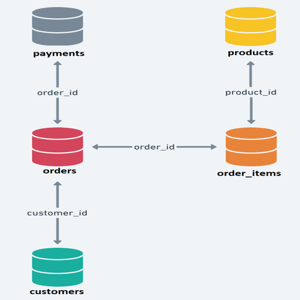

In [6]:
# Let's first load all the excel sheets in seperate dataframes.

In [7]:
df_data_dict = pd.read_excel(xls,sheet_name='Data Dictionary')
df_data_dict

,Dataset name,Column Name,Description
0,orders,order_id,"Unique identifier for an order, acts as the primary key of this table"
1,orders,customer_id,"Unique identifier for a customer, however, this table wont be unique at this level"
2,orders,order_status,"Indicates the status of an order, for example: delivered, cancelled, processing etc."
3,orders,order_purchase_timestamp,Timestamp when the order was made from the customer
4,orders,order_approved_at,Timestamp when the order was approved from the sellers' side
5,orders,order_delivered_timestamp,Timestamp when the order was delivered at customer's location
6,orders,order_estimated_delivery_date,Estimated date of delivery shared with the customer while placing the order
7,order_items,order_id,Unique identifier for an order
8,order_items,order_item_id,Item number in each order. Order_id along with this column acts as the primary key of this table
9,order_items,product_id,Unique identifier for a product


In [8]:
df_orders = pd.read_excel(xls,sheet_name="orders")
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [9]:
# as we are only interested in delivered orders, we will filter out orders with order status as delivered
df_orders = df_orders[df_orders.order_status=='delivered']

In [10]:
df_ord_items= pd.read_excel(xls,sheet_name="order_items")
df_ord_items.head()

,order_id,order_item_id,product_id,seller_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [11]:
df_customers= pd.read_excel(xls,sheet_name="customers")
df_customers.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [12]:
df_payments= pd.read_excel(xls,sheet_name="payments")
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [13]:
df_products= pd.read_excel(xls,sheet_name="products")
df_products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


# 2. Sanity checks and Outliers detection

### 2.1 Orders Dataframe

In [14]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  datetime64[ns]
 5   order_delivered_timestamp      96470 non-null  datetime64[ns]
 6   order_estimated_delivery_date  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](4), object(3)
memory usage: 5.9+ MB


In [15]:
for i in df_orders.columns:
    print(f"duplicate values in {i}:", df_orders[i].duplicated().sum())

duplicate values in order_id: 0
duplicate values in customer_id: 3120
duplicate values in order_status: 96477
duplicate values in order_purchase_timestamp: 522
duplicate values in order_approved_at: 8203
duplicate values in order_delivered_timestamp: 819
duplicate values in order_estimated_delivery_date: 96033


- the primary key, order_id, does not contain any duplicates

In [16]:
# as we are only considering delivered orders, we can even drop order_status column

df_orders_cleaned = df_orders.drop('order_status',axis=1)
df_orders_cleaned.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [17]:
df_orders_cleaned.isna().sum()

order_id                          0
customer_id                       0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_timestamp         8
order_estimated_delivery_date     0
dtype: int64

In [18]:
# let's see the null value columns

df_orders_cleaned[df_orders_cleaned.order_approved_at.isna() 
                  | df_orders_cleaned.order_delivered_timestamp.isna()].sort_values(by='order_purchase_timestamp')

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
26800,c1d4211b3dae76144deccd6c74144a88,6ff8b0d7b35d5c945633b8d60165691b,2017-01-19 12:48:08,NaT,2017-01-30 18:16:01,2017-03-01
48401,7002a78c79c519ac54022d4f8a65e6e8,d49f3dae6bad25d05160fc17aca5942d,2017-01-19 22:26:59,NaT,2017-02-06 14:22:19,2017-03-16
23156,12a95a3c06dbaec84bcfb0e2da5d228a,c8822fce1d0bfa7ddf0da24fff947172,2017-02-17 13:05:55,NaT,2017-03-02 11:09:19,2017-03-20
72407,3c0b8706b065f9919d0505d3b3343881,c094ac95fcd52f821809ec232a7a6956,2017-02-17 15:53:27,NaT,2017-03-03 11:47:47,2017-03-23
61743,2eecb0d85f281280f79fa00f9cec1a95,5a4fa4919cbf2b049e72be460a380e5b,2017-02-17 17:21:55,NaT,2017-03-03 12:16:03,2017-03-20
39334,d77031d6a3c8a52f019764e68f211c69,c4c0011e639bdbcf26059ddc38bd3c18,2017-02-18 11:04:19,NaT,2017-03-02 16:15:23,2017-03-22
16567,8a9adc69528e1001fc68dd0aaebbb54a,91efb7fcabc17925099dced52435837f,2017-02-18 12:45:31,NaT,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,e1f01a1bd6485e58ad3c769a5427d8a8,2017-02-18 13:29:47,NaT,2017-03-01 08:07:38,2017-03-17
5323,e04abd8149ef81b95221e88f6ed9ab6a,8a9a08c7ca8900a200d83cf838a07e0b,2017-02-18 14:40:00,NaT,2017-03-01 13:25:33,2017-03-17
63052,51eb2eebd5d76a24625b31c33dd41449,79af1bbf230a2630487975aa5d7d6220,2017-02-18 15:52:27,NaT,2017-03-07 13:57:47,2017-03-29


- It can be observed that the missing values in 'order_approved_at' variable mostly belong to 'order_purchase_timestamp' date between 17th and 18th feb, 2017. so we can say that the missing values are dependent on 'order_purchase_timestamp' column, and can be categorised into 'Missing At Random' (MAR) category. So we will impute the missing values with the help of average time between 17th and 18th feb,2017 required to approve the order once purchased.

- Whereas the missing values from 'order_delivered_timestamp' seems to be 'missing completely at random'. So we will impute the missing values with overall average delivery time once order is approved.

In [19]:
#  Let's find out the time required for approval after purchase order has been placed.

orders_approved_not_null = df_orders_cleaned[(df_orders_cleaned.order_purchase_timestamp>=pd.to_datetime('2017-02-17',format="%Y-%m-%d")) & (df_orders_cleaned.order_purchase_timestamp<=pd.to_datetime('2017-02-18',format="%Y-%m-%d")) & (~df_orders_cleaned.order_approved_at.isna())][['order_purchase_timestamp','order_approved_at']]
orders_approved_not_null['approval_delay']=orders_approved_not_null.order_approved_at-orders_approved_not_null.order_purchase_timestamp
orders_approved_not_null

,order_purchase_timestamp,order_approved_at,approval_delay
462,2017-02-17 17:37:52,2017-02-17 17:50:12,0 days 00:12:20
1104,2017-02-17 19:52:15,2017-02-18 19:55:11,1 days 00:02:56
1973,2017-02-17 00:29:34,2017-02-17 01:06:04,0 days 00:36:30
4191,2017-02-17 16:23:11,2017-02-17 16:35:22,0 days 00:12:11
5816,2017-02-17 22:34:14,2017-02-17 22:45:08,0 days 00:10:54
8308,2017-02-17 23:07:09,2017-02-17 23:22:39,0 days 00:15:30
15101,2017-02-17 19:05:22,2017-02-17 19:23:02,0 days 00:17:40
18875,2017-02-17 12:40:16,2017-02-17 13:05:27,0 days 00:25:11
19201,2017-02-17 13:53:06,2017-02-17 14:05:20,0 days 00:12:14
20203,2017-02-17 10:32:57,2017-02-18 03:15:10,0 days 16:42:13


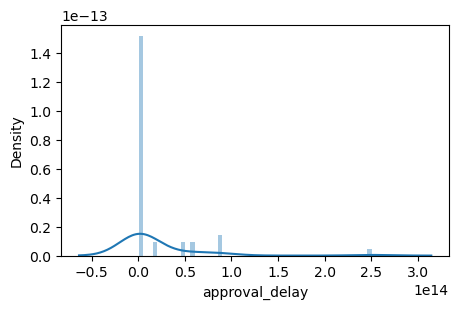

In [20]:
# firstly, let's check distribution of approval_delay

plt.figure(figsize=(5,3))
sns.distplot(orders_approved_not_null['approval_delay'])
plt.show()

- outliers are present, so we will use median.

In [21]:
# imputing the missing values in order_approved_at column by calculating average time 
# required to approve the order after purchase and adding that time to purchase time.

In [22]:
avg_approval_delay = orders_approved_not_null['approval_delay'].median()
avg_approval_delay

Timedelta('0 days 00:14:13.500000')

In [23]:
df_orders_cleaned['order_approved_at'].fillna(df_orders_cleaned.order_purchase_timestamp+avg_approval_delay,inplace=True)

In [24]:
# Let's handle missing values from 'order_delivered_timestamp' column.

In [25]:
# By looking at missing values from 'order_delivered_timestamp', we could not deduce any pattern in their missingness.
# let's impute with median value of delivery time.

In [26]:
orders_delivered_not_null = df_orders_cleaned[~df_orders_cleaned.order_delivered_timestamp.isna()][['order_purchase_timestamp','order_approved_at','order_delivered_timestamp']]
orders_delivered_not_null['delivery_time']=orders_delivered_not_null.order_delivered_timestamp-orders_delivered_not_null.order_approved_at
orders_delivered_not_null.sort_values("delivery_time")

,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,delivery_time
31211,2017-09-01 20:05:42,2017-09-13 22:00:51,2017-09-06 22:15:45,-7 days +00:14:54
14562,2017-09-01 19:04:22,2017-09-13 22:06:11,2017-09-08 20:13:03,-6 days +22:06:52
41592,2017-09-01 18:40:44,2017-09-13 21:58:04,2017-09-08 20:07:45,-6 days +22:09:41
85393,2017-09-01 20:05:55,2017-09-13 21:58:38,2017-09-08 20:41:16,-6 days +22:42:38
91801,2018-08-09 20:45:10,2018-08-20 15:56:29,2018-08-15 14:56:43,-6 days +23:00:14
...,...,...,...,...
61610,2017-03-07 23:59:51,2017-03-09 01:11:33,2017-09-19 15:12:50,194 days 14:01:17
89130,2017-03-08 22:47:40,2017-03-08 22:47:40,2017-09-19 14:00:04,194 days 15:12:24
70307,2017-03-08 18:09:02,2017-03-08 18:09:02,2017-09-19 14:33:17,194 days 20:24:15
55619,2018-02-23 14:57:35,2018-02-23 15:16:14,2018-09-19 23:24:07,208 days 08:07:53


- We are getting delivery_time as negative in some records, which means that there must be some issue with the orders approval or orders delivery timestamp.

In [27]:
# let's check the records where order_approved_at > order_delivered_timestamp

In [28]:
idx = orders_delivered_not_null[orders_delivered_not_null.order_delivered_timestamp<
                                orders_delivered_not_null.order_approved_at].index

df_orders_cleaned.loc[idx].sort_values(by='order_purchase_timestamp').iloc[:,2:]

,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
25411,2017-02-19 01:15:03,2017-03-01 10:51:46,2017-02-24 14:27:26,2017-03-17
66460,2017-06-26 12:23:32,2017-07-05 17:09:11,2017-07-03 17:53:29,2017-07-18
68417,2017-09-01 18:40:11,2017-09-13 22:04:49,2017-09-12 16:53:41,2017-09-22
41592,2017-09-01 18:40:44,2017-09-13 21:58:04,2017-09-08 20:07:45,2017-10-02
11738,2017-09-01 18:45:33,2017-09-13 22:04:39,2017-09-11 14:15:02,2017-09-21
14562,2017-09-01 19:04:22,2017-09-13 22:06:11,2017-09-08 20:13:03,2017-09-20
46163,2017-09-01 20:04:28,2017-09-13 22:17:15,2017-09-09 15:12:44,2017-09-20
27309,2017-09-01 20:04:47,2017-09-13 22:08:55,2017-09-11 16:43:46,2017-09-20
31211,2017-09-01 20:05:42,2017-09-13 22:00:51,2017-09-06 22:15:45,2017-09-20
85393,2017-09-01 20:05:55,2017-09-13 21:58:38,2017-09-08 20:41:16,2017-09-22


In [29]:
# df_orders_cleaned.loc[idx].sort_values(by='order_purchase_timestamp')['order_purchase_timestamp']

- In the above records, the orders have been approved after they are updated as delivered, which clearly signifies some issue in the records.
- We can rule out the possibility that in above records, delivered and approved time have been swapped with each other because in some records the delivery time after approval would become few minuts (as low as approx 5 mins), which does not seem fisible.
- If we observe carefully, the some of the orders on days like 2017-09-13,2018-04-24,2018-07-05,etc.. have been approved sequencially with very short timespan in between them. This shows that the orders were delivered without being approved and later on marked approved once delivery time has been updated.
- So, we will replace the above values from 'order_approved_at' column with avg_time required for approval after purchase.

In [30]:
df_approval_time = df_orders_cleaned[~df_orders_cleaned.index.isin(idx)][['order_purchase_timestamp','order_approved_at']]
df_approval_time['approval_time'] = df_approval_time.order_approved_at-df_approval_time.order_purchase_timestamp
df_approval_time.sort_values('approval_time')

,order_purchase_timestamp,order_approved_at,approval_time
50523,2017-03-16 19:38:01,2017-03-16 19:38:01,0 days 00:00:00
23599,2017-03-26 16:14:02,2017-03-26 16:14:02,0 days 00:00:00
46166,2017-03-15 11:20:40,2017-03-15 11:20:40,0 days 00:00:00
59178,2017-03-14 16:47:29,2017-03-14 16:47:29,0 days 00:00:00
81542,2017-03-08 16:06:00,2017-03-08 16:06:00,0 days 00:00:00
...,...,...,...
73881,2017-05-26 15:30:49,2017-06-08 23:02:47,13 days 07:31:58
71651,2018-03-12 15:21:32,2018-03-29 11:35:16,16 days 20:13:44
88671,2017-12-04 11:15:54,2017-12-27 14:03:00,23 days 02:47:06
55708,2018-01-20 17:38:58,2018-02-20 12:05:54,30 days 18:26:56


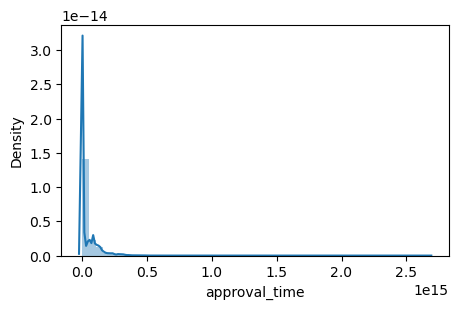

In [31]:
# checking distribution of approval_time

plt.figure(figsize=(5,3))
sns.distplot(df_approval_time.approval_time)
plt.show()

- we will use median because of outliers

In [32]:
avg_approval_time = df_approval_time.approval_time.median()
avg_approval_time

Timedelta('0 days 00:20:35')

In [33]:
# let's correct the records in 'order_approved_at' column which were updated after delivery. 

df_orders_cleaned.loc[idx,'order_approved_at'] = df_orders_cleaned.order_purchase_timestamp + avg_approval_time

In [34]:
# Now the records have been cleaned, Let's find out average order_delivered_timestamp.

In [35]:
orders_delivered_not_null = df_orders_cleaned[~df_orders_cleaned.order_delivered_timestamp.isna()][['order_approved_at','order_delivered_timestamp']]
orders_delivered_not_null['delivery_time'] = orders_delivered_not_null.order_delivered_timestamp-orders_delivered_not_null.order_approved_at
orders_delivered_not_null.sort_values('delivery_time')

,order_approved_at,order_delivered_timestamp,delivery_time
25702,2018-04-24 18:05:57,2018-04-24 18:16:59,0 days 00:11:02
4061,2018-04-24 18:55:14,2018-04-24 19:11:46,0 days 00:16:32
98710,2017-09-13 22:03:51,2017-09-13 22:24:46,0 days 00:20:55
23566,2018-04-24 18:53:22,2018-04-24 19:17:28,0 days 00:24:06
80928,2018-04-24 19:18:43,2018-04-24 19:51:47,0 days 00:33:04
...,...,...,...
61610,2017-03-09 01:11:33,2017-09-19 15:12:50,194 days 14:01:17
89130,2017-03-08 22:47:40,2017-09-19 14:00:04,194 days 15:12:24
70307,2017-03-08 18:09:02,2017-09-19 14:33:17,194 days 20:24:15
55619,2018-02-23 15:16:14,2018-09-19 23:24:07,208 days 08:07:53


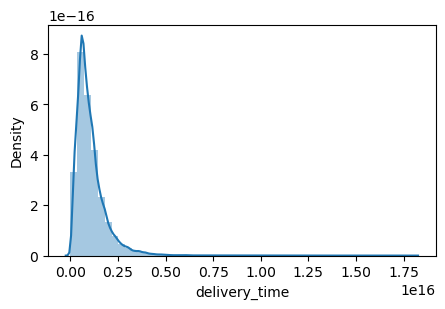

In [36]:
# Checking distribution of 'delivery_time'

plt.figure(figsize=(5,3))
sns.distplot(orders_delivered_not_null['delivery_time'])
plt.show()

- Now, the delivery time distribution is correct and we will use median to impute the missing values

In [37]:
avg_delivery_time = orders_delivered_not_null['delivery_time'].median()
avg_delivery_time

Timedelta('9 days 20:28:19')

In [38]:
df_orders_cleaned['order_delivered_timestamp'].fillna(df_orders_cleaned.order_approved_at+avg_delivery_time,inplace=True)

In [39]:
df_orders_cleaned.reset_index(drop=True,inplace=True)

In [40]:
df_orders_cleaned.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26


In [41]:
# let's create a new variable 'Month-Year' from simple visualisation perspective

df_orders_cleaned['order_yr_mon'] = df_orders_cleaned.order_purchase_timestamp.apply(lambda x:pd.to_datetime(str(x.month)+"-"+str(x.year),format='%m-%Y'))

In [42]:
# let's create a new variable to identify whether the order was delayed or not?

df_orders_cleaned['is_order_delayed'] = df_orders_cleaned.apply(lambda x:"Delayed" 
                                                                if x['order_estimated_delivery_date']<x['order_delivered_timestamp']
                                                                else "Not Delayed",axis=1)

In [43]:
df_orders_cleaned.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,order_yr_mon,is_order_delayed
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10-01,Not Delayed
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,2018-07-01,Not Delayed
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,2018-08-01,Not Delayed
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,2017-11-01,Not Delayed
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,2018-02-01,Not Delayed


In [44]:
# finally, lets convert object data to categorical data

for col in df_orders_cleaned.select_dtypes("object").columns:
    df_orders_cleaned[col] = df_orders_cleaned[col].astype("category")

In [45]:
df_orders_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  category      
 1   customer_id                    96478 non-null  category      
 2   order_purchase_timestamp       96478 non-null  datetime64[ns]
 3   order_approved_at              96478 non-null  datetime64[ns]
 4   order_delivered_timestamp      96478 non-null  datetime64[ns]
 5   order_estimated_delivery_date  96478 non-null  datetime64[ns]
 6   order_yr_mon                   96478 non-null  datetime64[ns]
 7   is_order_delayed               96478 non-null  category      
dtypes: category(3), datetime64[ns](5)
memory usage: 10.0 MB


### 2.2 Ordered Items Dataframe

In [46]:
df_ord_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   order_id          112650 non-null  object 
 1   order_item_id     112650 non-null  int64  
 2   product_id        112650 non-null  object 
 3   seller_id         112650 non-null  object 
 4   price             112650 non-null  float64
 5   shipping_charges  112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.2+ MB


In [47]:
# here, we do not have any information of sellers other than their ids, which is not of much use, so let's drop that column.

df_ord_items.drop('seller_id',axis=1,inplace=True)

In [48]:
# let's check for duplicate values by consideing 'order_id','order_item_id' as composite primary key.

df_ord_items.set_index(['order_id','order_item_id']).index.duplicated().sum()

0

In [49]:
df_ord_items[['price','shipping_charges']].describe()

,price,shipping_charges
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


We can definitely observe outliers, we will look into it on later stage

In [50]:
# lets check the order_item_id column for any anomaly. 

df_ord_items['order_item_id'].value_counts()

1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: order_item_id, dtype: int64

In [51]:
# We can convert order_item_id variable along with object variables to categorical variable.

In [52]:
for col in ['order_id', 'product_id']:
    df_ord_items[col] = df_ord_items[col].astype("category")

In [53]:
df_ord_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   order_id          112650 non-null  category
 1   order_item_id     112650 non-null  int64   
 2   product_id        112650 non-null  category
 3   price             112650 non-null  float64 
 4   shipping_charges  112650 non-null  float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 7.5 MB


### 2.3 Customers Dataframe

In [54]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_zip_code_prefix  99441 non-null  int64 
 2   customer_city             99441 non-null  object
 3   customer_state            99441 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.0+ MB


In [55]:
df_customers.shape

(99441, 4)

In [56]:
# let's check for duplicate values
for i in df_customers.columns:
    print(f"duplicate values in {i}:", df_customers[i].duplicated().sum())

duplicate values in customer_id: 3345
duplicate values in customer_zip_code_prefix: 84447
duplicate values in customer_city: 95322
duplicate values in customer_state: 99414


- The customer_id is primary key for this dataset and it contains 3345 duplicate values.

In [57]:
# let's drop these duplicate values 

df_customers_cleaned = df_customers.drop_duplicates(subset=['customer_id'], keep='first')

In [58]:
df_customers_cleaned = df_customers_cleaned.reset_index(drop=True)
df_customers_cleaned

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...
96091,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
96092,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
96093,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
96094,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [59]:
# Finally, lets convert all the object columns to categorical along with zip_code column
for col in df_customers_cleaned.columns:
    df_customers_cleaned[col] = df_customers_cleaned[col].astype('category')

In [60]:
df_customers_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_id               96096 non-null  category
 1   customer_zip_code_prefix  96096 non-null  category
 2   customer_city             96096 non-null  category
 3   customer_state            96096 non-null  category
dtypes: category(4)
memory usage: 4.4 MB


### 2.4 Payments Dataframe

In [61]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [62]:
# let's check for duplicate values
for i in df_payments.columns:
    print(f"duplicate values in {i}:", df_payments[i].duplicated().sum())

duplicate values in order_id: 4446
duplicate values in payment_sequential: 103857
duplicate values in payment_type: 103881
duplicate values in payment_installments: 103862
duplicate values in payment_value: 74809


- The order_id contains some duplicate values but its acceptable, as for one order there can be multiple sequence of payments which can lead to duplicate order_id.

In [63]:
#  let's check if 'order_id','payment_sequential' together gives us any duplicate values
df_payments.set_index(['order_id','payment_sequential']).index.duplicated().sum()

0

In [64]:
for i in ['payment_sequential','payment_installments','payment_type']:
    print(df_payments[i].value_counts(),end="\n\n")

1     99360
2      3039
3       581
4       278
5       170
6       118
7        82
8        54
9        43
10       34
11       29
12       21
13       13
14       10
15        8
18        6
19        6
16        6
17        6
21        4
20        4
22        3
26        2
24        2
23        2
25        2
29        1
28        1
27        1
Name: payment_sequential, dtype: int64

1     52546
2     12413
3     10461
4      7098
10     5328
5      5239
8      4268
6      3920
7      1626
9       644
12      133
15       74
18       27
11       23
24       18
20       17
13       16
14       15
17        8
16        5
21        3
0         2
22        1
23        1
Name: payment_installments, dtype: int64

credit_card    76795
wallet         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64



In [65]:
#  let's check the payment_type variable as it is the only categorical variable with some null values

In [66]:
df_payments[df_payments.payment_type=='not_defined']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0


In [67]:
# the payment_value corresponding to payment_type not_defined is 0, let's check the same for all the 
# records having 0 payment_value

In [68]:
df_payments[df_payments.payment_value==0]

,order_id,payment_sequential,payment_type,payment_installments,payment_value
19922,8bcbe01d44d147f901cd3192671144db,4,voucher,1,0.0
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.0
43744,6ccb433e00daae1283ccc956189c82ae,4,voucher,1,0.0
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.0
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.0
62674,45ed6e85398a87c253db47c2d9f48216,3,voucher,1,0.0
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.0
94427,c8c528189310eaa44a745b8d9d26908b,1,not_defined,1,0.0
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.0


In [69]:
# where ever payment_value is 0, the payment_type is voucher, so let's impute the null values with 'voucher'.

In [70]:
df_payments.loc[df_payments.payment_type=='not_defined','payment_type'] = 'voucher'

In [71]:
# Let's convert the variables to categorical data type

for col in ['order_id', 'payment_type',]:
    df_payments[col] = df_payments[col].astype("category")

### 2.5 Products dataframe

In [72]:
df_products.describe()

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32949.000000,32949.000000,32949.000000,32949.000000
mean,2276.472488,30.815078,16.937661,23.196728
std,4282.038731,16.914458,13.637554,12.079047
min,0.000000,7.000000,2.000000,6.000000
25%,300.000000,18.000000,8.000000,15.000000
50%,700.000000,25.000000,13.000000,20.000000
75%,1900.000000,38.000000,21.000000,30.000000
max,40425.000000,105.000000,105.000000,118.000000


In [73]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_category_name  32781 non-null  object 
 2   product_weight_g       32949 non-null  float64
 3   product_length_cm      32949 non-null  float64
 4   product_height_cm      32949 non-null  float64
 5   product_width_cm       32949 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


- null values are present in all the variables apart from product_id

In [74]:
# let's check for duplicate values

for i in df_products.columns:
    print(f"duplicate values in {i}:", df_products[i].duplicated().sum())

duplicate values in product_id: 0
duplicate values in product_category_name: 32880
duplicate values in product_weight_g: 30746
duplicate values in product_length_cm: 32851
duplicate values in product_height_cm: 32848
duplicate values in product_width_cm: 32855


- The primary key product_id does not have any duplicate values.

In [75]:
# let's check the null value count

df_products.isna().sum()

product_id                 0
product_category_name    170
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64

In [76]:
# let's first check for product weight variable
df_products[df_products.product_weight_g.isna()]

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,toys,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,toys,NaN,NaN,NaN,NaN


- It is evident that for the above product_id all the information related to product specification is missing. and the missingness is completely at random, we will impute them with median values because of presence of outliers.

In [77]:
# imputing null values with median
for col in ['product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']:
    df_products[col].fillna(df_products[col].median(),inplace=True)

In [78]:
# let's check missing value percentage from product_category_name
df_products.product_category_name.value_counts(normalize=True,dropna=False)*100

toys                                       75.035659
bed_bath_table                              2.394465
sports_leisure                              2.188097
furniture_decor                             2.084914
health_beauty                               1.966556
housewares                                  1.914965
auto                                        1.484022
computers_accessories                       1.289794
watches_gifts                               1.019696
telephony                                   0.867955
baby                                        0.749598
stationery                                  0.716215
perfumery                                   0.682832
fashion_bags_accessories                    0.643380
cool_stuff                                  0.591788
garden_tools                                0.561440
pet_shop                                    0.521987
NaN                                         0.515918
electronics                                 0.

- 75% of products belong to 'Toys' category and 0.5% are null values. let's impute null values with mode. 

In [79]:
mode = df_products.product_category_name.mode()[0]
mode

'toys'

In [80]:
# filling null values with mode
df_products.product_category_name.fillna(mode,inplace=True)

In [81]:
# changing object data type to categorical

for col in ['product_id','product_category_name']:
    df_products[col] = df_products[col].astype('category')

In [82]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   product_id             32951 non-null  category
 1   product_category_name  32951 non-null  category
 2   product_weight_g       32951 non-null  float64 
 3   product_length_cm      32951 non-null  float64 
 4   product_height_cm      32951 non-null  float64 
 5   product_width_cm       32951 non-null  float64 
dtypes: category(2), float64(4)
memory usage: 2.4 MB


# 3. Univariate Analysis and Detection of Outliers


- Our aim is to 
1) Understand the distribution of numerical and categorical data. 
2) Check for presence of outliers in numerical data.

### 3.1 Orderes data

In [83]:
df_orders_cleaned.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_timestamp,order_estimated_delivery_date,order_yr_mon,is_order_delayed
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10-01,Not Delayed
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,2018-07-01,Not Delayed
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,2018-08-01,Not Delayed
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,2017-11-01,Not Delayed
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,2018-02-01,Not Delayed


In [84]:
df_orders_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  category      
 1   customer_id                    96478 non-null  category      
 2   order_purchase_timestamp       96478 non-null  datetime64[ns]
 3   order_approved_at              96478 non-null  datetime64[ns]
 4   order_delivered_timestamp      96478 non-null  datetime64[ns]
 5   order_estimated_delivery_date  96478 non-null  datetime64[ns]
 6   order_yr_mon                   96478 non-null  datetime64[ns]
 7   is_order_delayed               96478 non-null  category      
dtypes: category(3), datetime64[ns](5)
memory usage: 10.0 MB


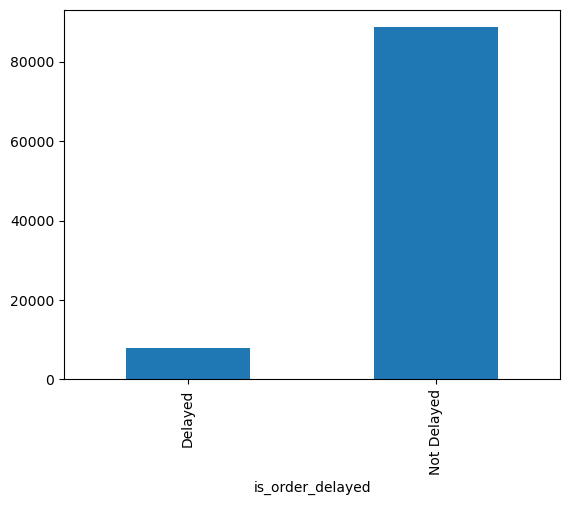

In [85]:
# count of delayed vs not delayed orders

df_orders_cleaned.groupby("is_order_delayed")['order_id'].count().plot.bar()
plt.show()

- majority of orders were delivered on or before time.

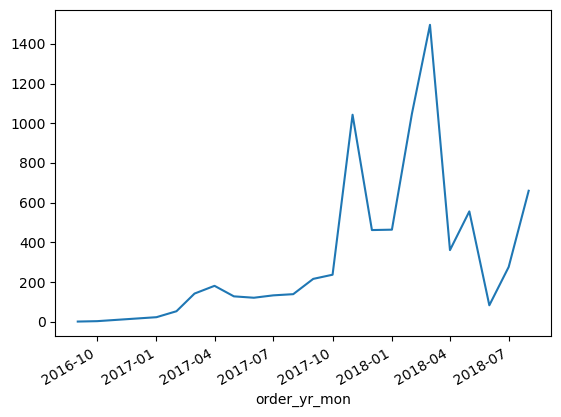

In [86]:
# most delayed order month-year

df_orders_cleaned[df_orders_cleaned.is_order_delayed=="Delayed"].groupby('order_yr_mon')['order_id'].count().sort_index().plot()
plt.show()

- The number of orders delayed were highest in '03-2018' followed by '02-2018'

### 3.2 Ordered Items data

In [87]:
df_ord_items.head()

,order_id,order_item_id,product_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14


In [88]:
df_ord_items.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.99])

,order_item_id,price,shipping_charges
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
90%,2.000000,229.800000,34.041000
95%,2.000000,349.900000,45.120000
99%,4.000000,890.000000,84.520000


- the difference between 99th percentile and max value in 'price' and 'shipping_charges' is quite large, which signifies presence of outliers. we will check the distribution and take decision accordingly.

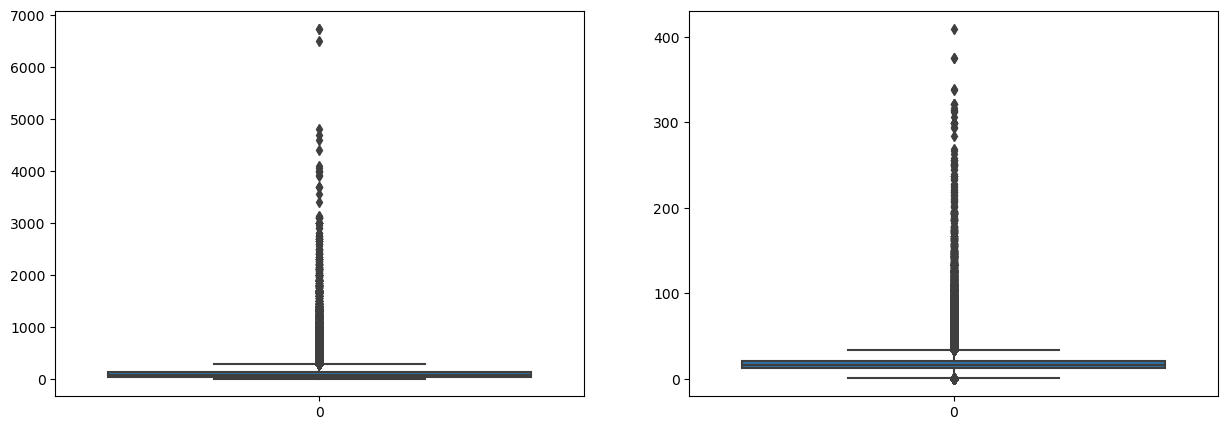

In [89]:
plt.figure(figsize=(15,5))
for i,j in enumerate(['price','shipping_charges']):
    plt.subplot(1,2,i+1)
    sns.boxplot(df_ord_items[j])
plt.show()

skewness in price distribution: 7.92
skewness in shipping_charges distribution: 5.64


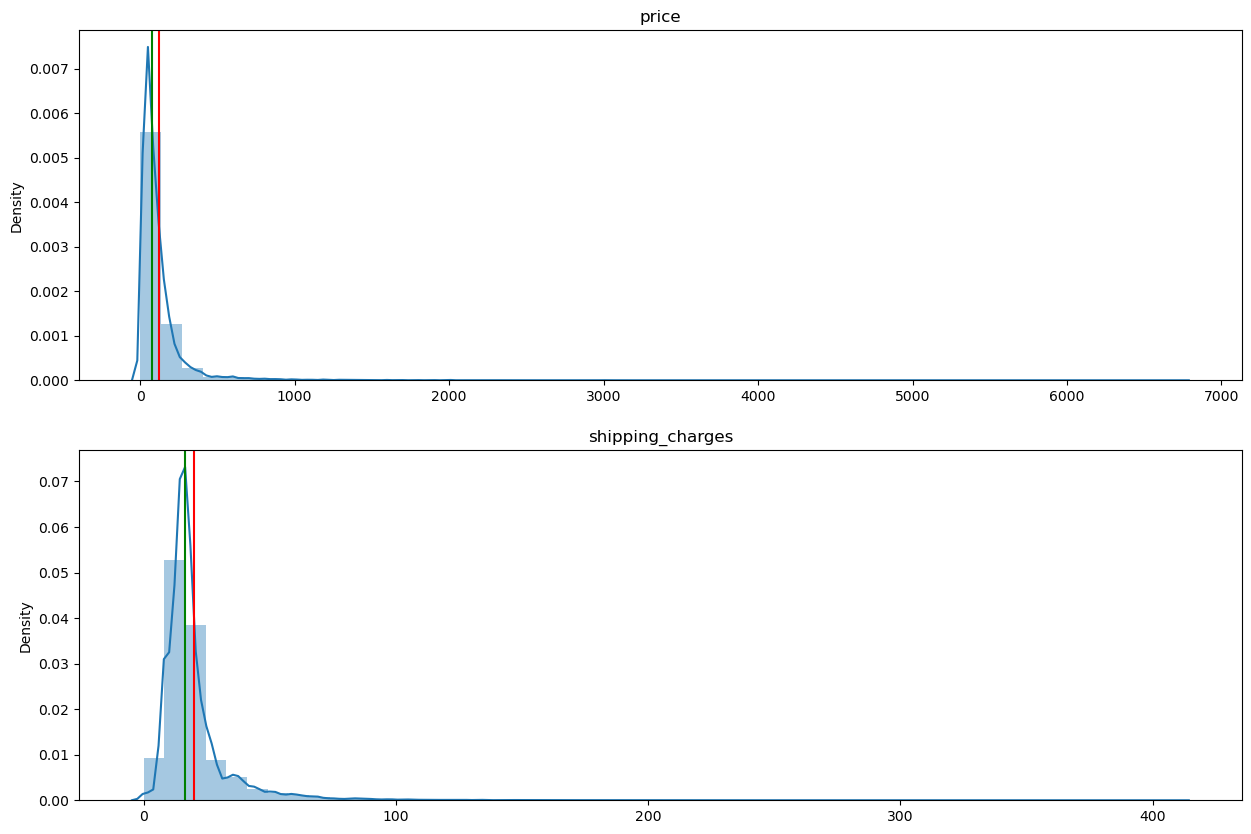

In [90]:
plt.figure(figsize=(15,10))
for i,j in enumerate(['price','shipping_charges']):
    plt.subplot(2,1,i+1)
    sns.distplot(df_ord_items[j])
    plt.axvline(df_ord_items[j].mean(), color="red")
    plt.axvline(df_ord_items[j].median(), color="green")
    plt.xlabel(None)
    print(f"skewness in {j} distribution:", round(df_ord_items[j].skew(),2))
    plt.title(j)
plt.show()

- all of the distributions are positively skewed, which denotes that the outliers are present towards the right of the distribution

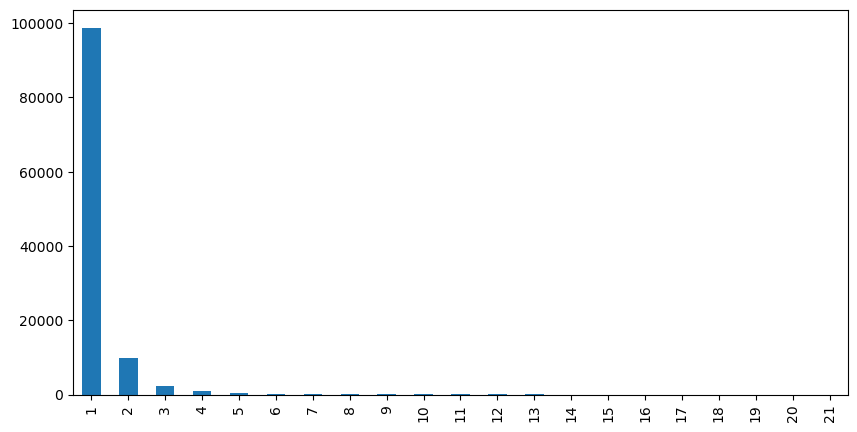

In [91]:
plt.figure(figsize=(10,5))
df_ord_items.order_item_id.value_counts().plot.bar()
plt.show()

- Majority of orders consists of item_no 1. We can sday that item_no 1 is the most popular product.

### 3.3 Products data

In [92]:
df_products.head()

,product_id,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,625.0,20.0,17.0,13.0


In [93]:
df_products.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.99])

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951.000000,32951.000000,32951.000000,32951.000000
mean,2276.376802,30.814725,16.937422,23.196534
std,4281.926387,16.914005,13.637175,12.078707
min,0.000000,7.000000,2.000000,6.000000
25%,300.000000,18.000000,8.000000,15.000000
50%,700.000000,25.000000,13.000000,20.000000
75%,1900.000000,38.000000,21.000000,30.000000
90%,6300.000000,53.000000,33.000000,40.000000
95%,10850.000000,65.000000,44.000000,47.000000
99%,22537.500000,100.000000,69.000000,63.000000


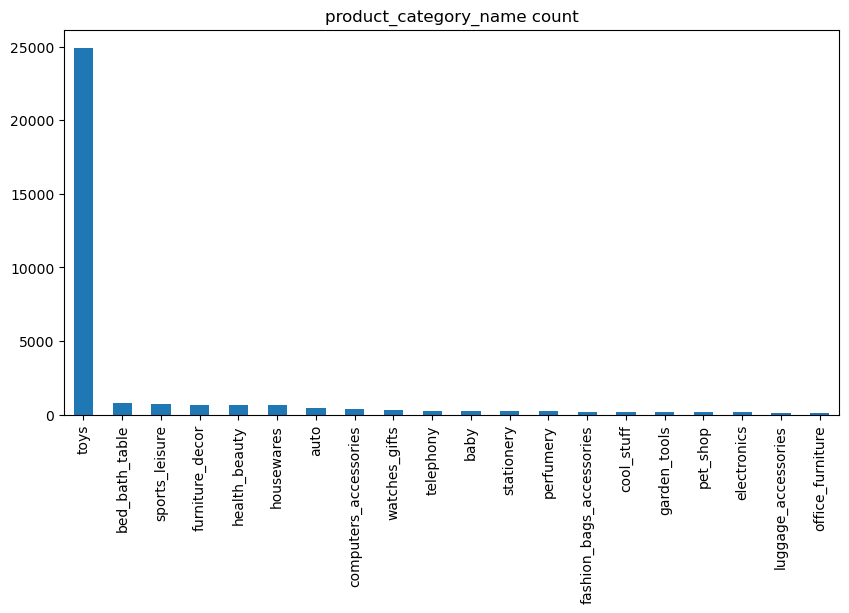

In [94]:
#  top 20 product categories
plt.figure(figsize=(10,5))
(df_products.product_category_name.value_counts()[:20]).plot.bar()
plt.title("product_category_name count")
plt.show()

- Toys are the most popular product category

In [95]:
prod_num_cols = df_products.select_dtypes('float64').columns
prod_num_cols

Index(['product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm'],
      dtype='object')

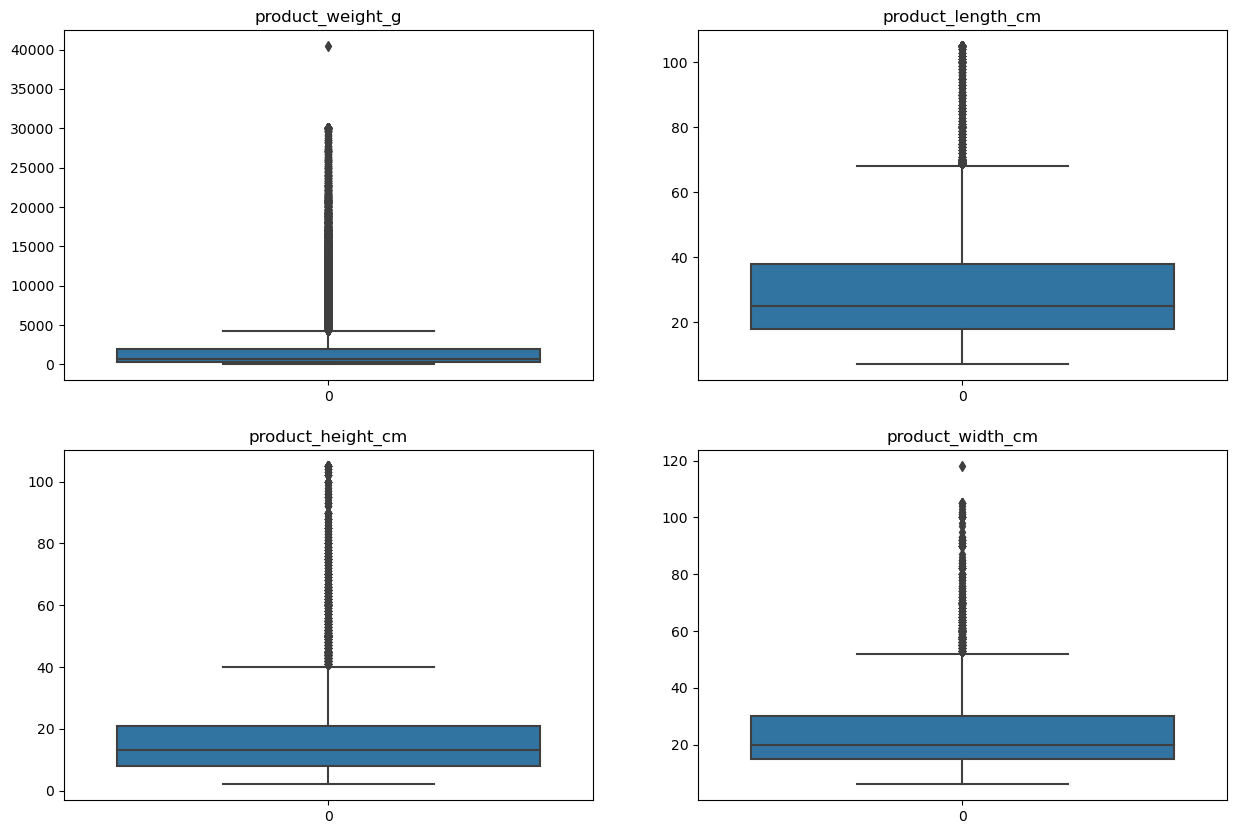

In [96]:
plt.figure(figsize=(15,10))
for i,j in enumerate(prod_num_cols,1):
    plt.subplot(2,2,i)
    sns.boxplot(df_products[j])
    plt.title(j)
plt.show()

- In all the variables, outliers are present

skewness in product_weight_g distribution: 3.6
skewness in product_length_cm distribution: 1.75
skewness in product_height_cm distribution: 2.14
skewness in product_width_cm distribution: 1.67


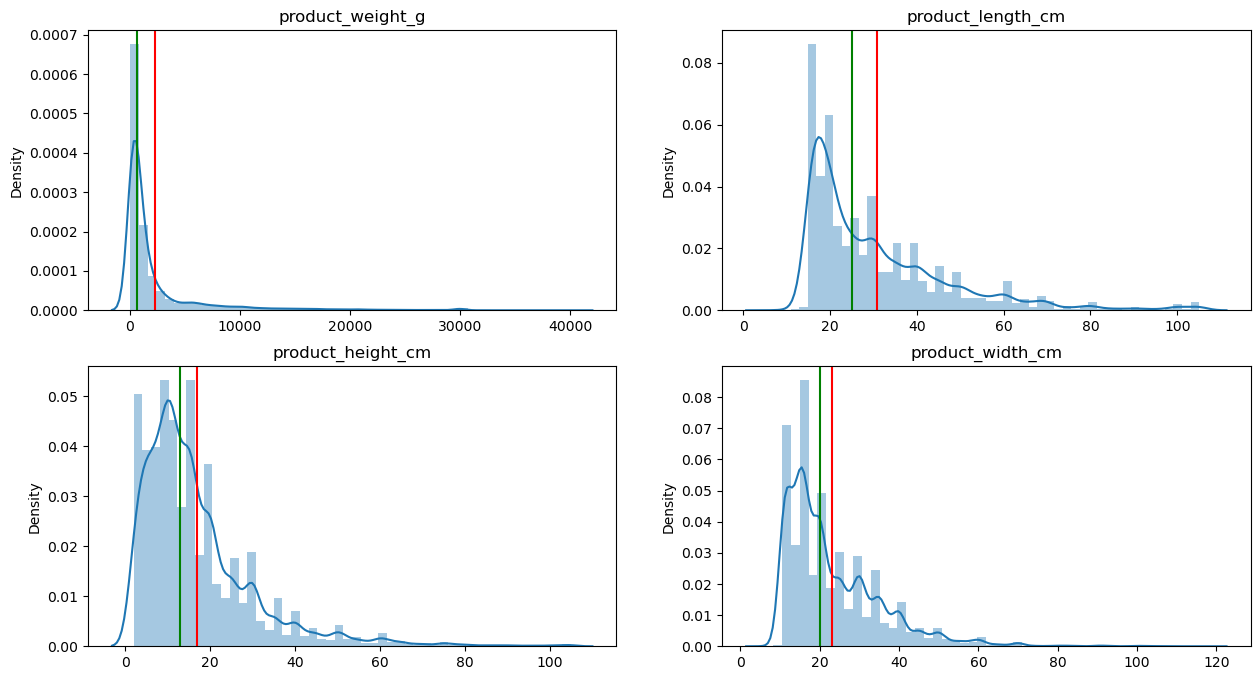

In [97]:
plt.figure(figsize=(15,8))
for i,j in enumerate(prod_num_cols,1):
    plt.subplot(2,2,i)
    sns.distplot(df_products[j])
    plt.axvline(df_products[j].mean(),color='red')
    plt.axvline(df_products[j].median(),color='green')
    print(f"skewness in {j} distribution:", round(df_products[j].skew(),2))
    plt.xlabel(None)
    plt.title(j)
plt.show()

- all of the distributions are positively skewed, which denotes that the outliers are present towards the right of the distribution

### 3.4 Payments data

In [98]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [99]:
df_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


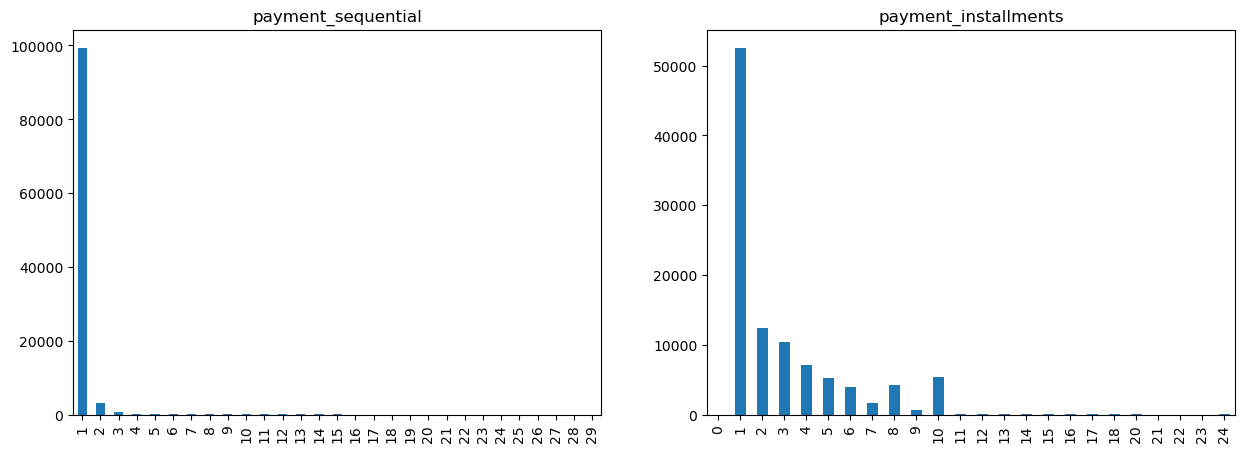

In [100]:
# although the payment_sequencials and payment_installments column is numerical, it has values from 1 to 29 and 0 to 24 respectively
# and it can be considered as categorical column, lets check the value count 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df_payments['payment_sequential'].value_counts().sort_index().plot.bar()
plt.title('payment_sequential')
plt.subplot(1,2,2)
df_payments['payment_installments'].value_counts().sort_index().plot.bar()
plt.title('payment_installments')
plt.show()

- Majority of orders were paid in single transaction only, i.e. only through 1 mode or source of payment.
- Majority of orders were paid in 1 installment. Also, we can observe a declining trend in the number of orders as the number of installments increases, with exception at 8 and 10 installments

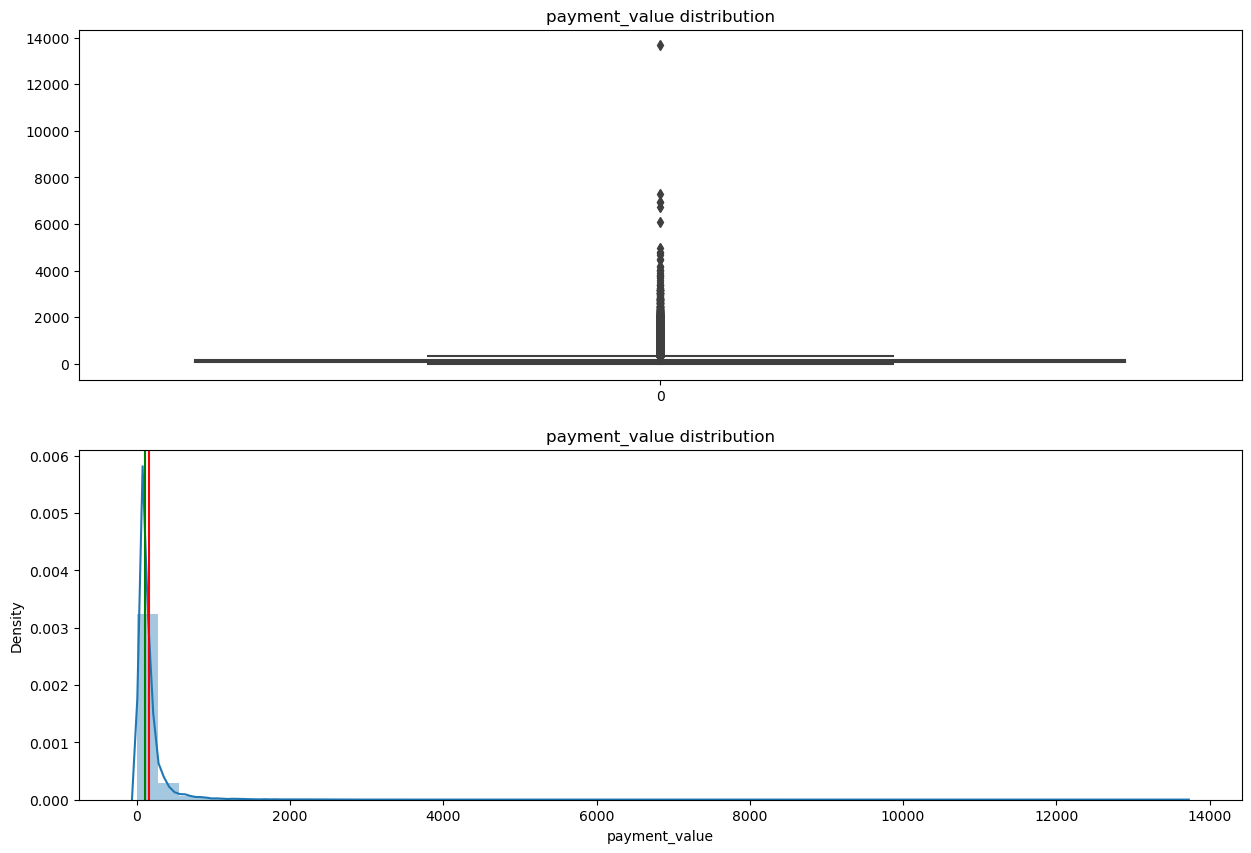

In [101]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.boxplot(df_payments['payment_value'])
plt.title('payment_value distribution')
plt.subplot(2,1,2)
sns.distplot(df_payments['payment_value'])
plt.axvline(df_payments['payment_value'].mean(),color='red')
plt.axvline(df_payments['payment_value'].median(),color='green')
plt.title('payment_value distribution')
plt.show()

- Outliers are present in the payments_value variable

### 3.5 Customer data

In [102]:
df_customers_cleaned.head()

,customer_id,customer_zip_code_prefix,customer_city,customer_state
0,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [103]:
df_customers_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_id               96096 non-null  category
 1   customer_zip_code_prefix  96096 non-null  category
 2   customer_city             96096 non-null  category
 3   customer_state            96096 non-null  category
dtypes: category(4)
memory usage: 4.4 MB


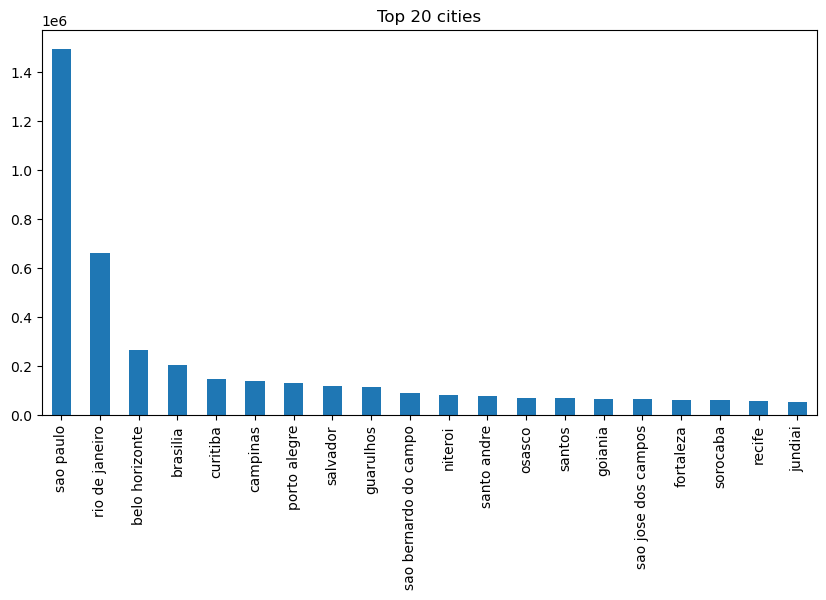

In [104]:
# only checking top 20 cities based on count
plt.figure(figsize=(10,5))
((df_customers_cleaned.customer_city.value_counts()*100)[:20]).plot.bar()
plt.title("Top 20 cities")
plt.show()

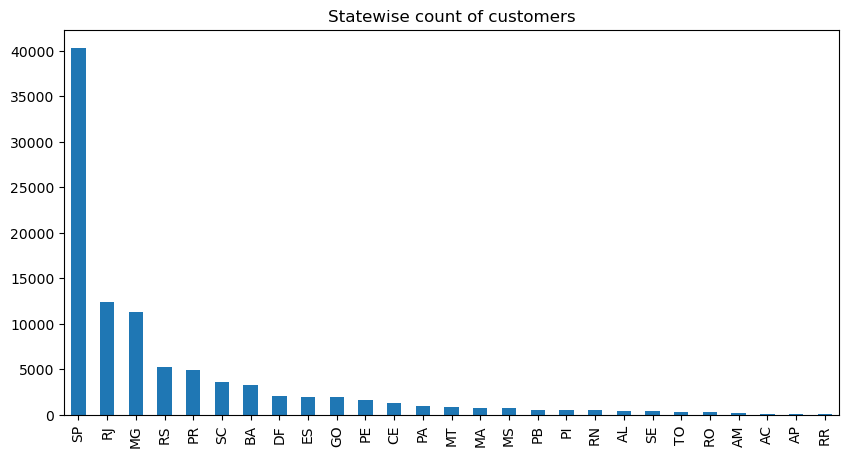

In [105]:
plt.figure(figsize=(10,5))
df_customers_cleaned.customer_state.value_counts().plot.bar()
plt.title("Statewise count of customers")
plt.show()

- SP has highest number of customers
- RR has lowest number of customers

# 4. Bivariate and Multivariate Analysis

### 4.1 Order Items Data

In [106]:
# barplot function
def bar_plot(df,x,y,estimator='mean'):
    plt.figure(figsize=(10,5))
    sns.barplot(data=df,x=x,y=y,estimator=estimator)
    plt.title(x+" Vs "+y)
    plt.show()

In [107]:
df_ord_items.head()

,order_id,order_item_id,product_id,price,shipping_charges
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14


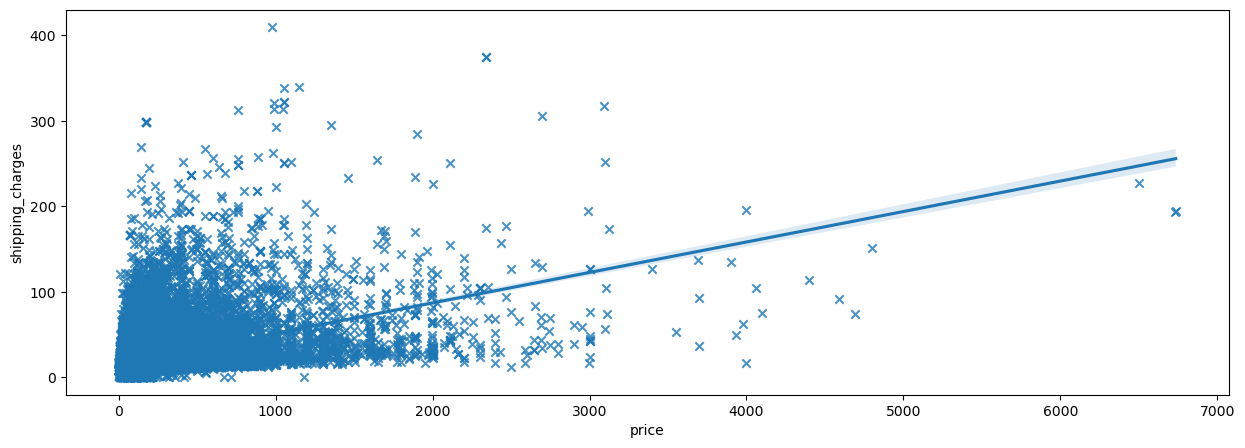

In [108]:
plt.figure(figsize=(15,5))
sns.regplot(data=df_ord_items,x='price',y='shipping_charges',marker='x')
plt.show()

- price and shipping charges are roughly showing positive correlation but it is quite weak.

### 4.2 Products data

In [109]:
num_cols = ['product_weight_g','product_length_cm','product_height_cm','product_width_cm']

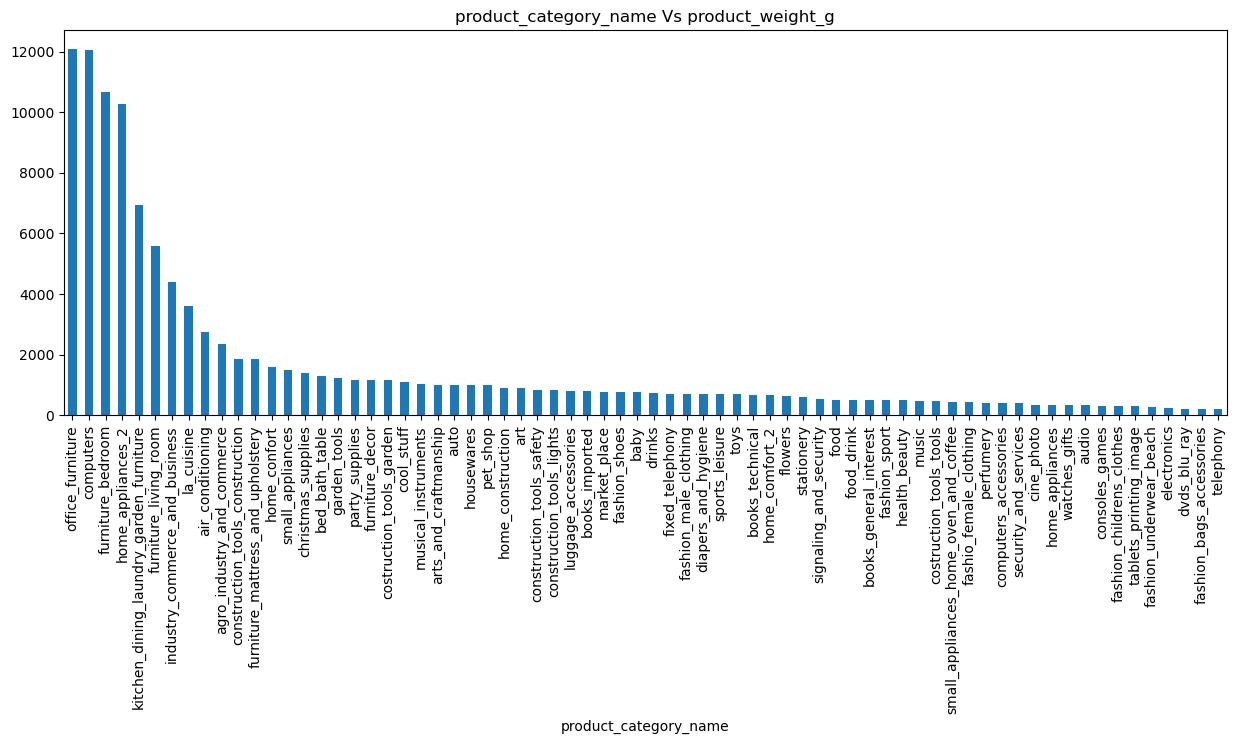

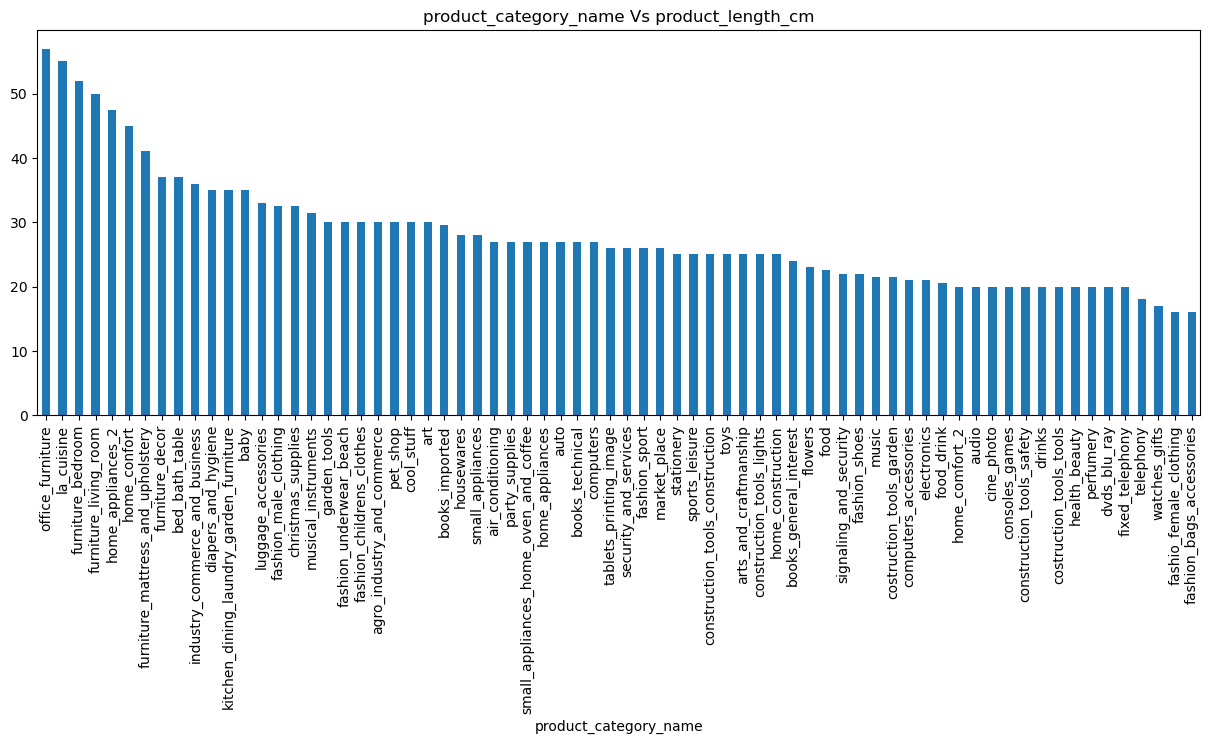

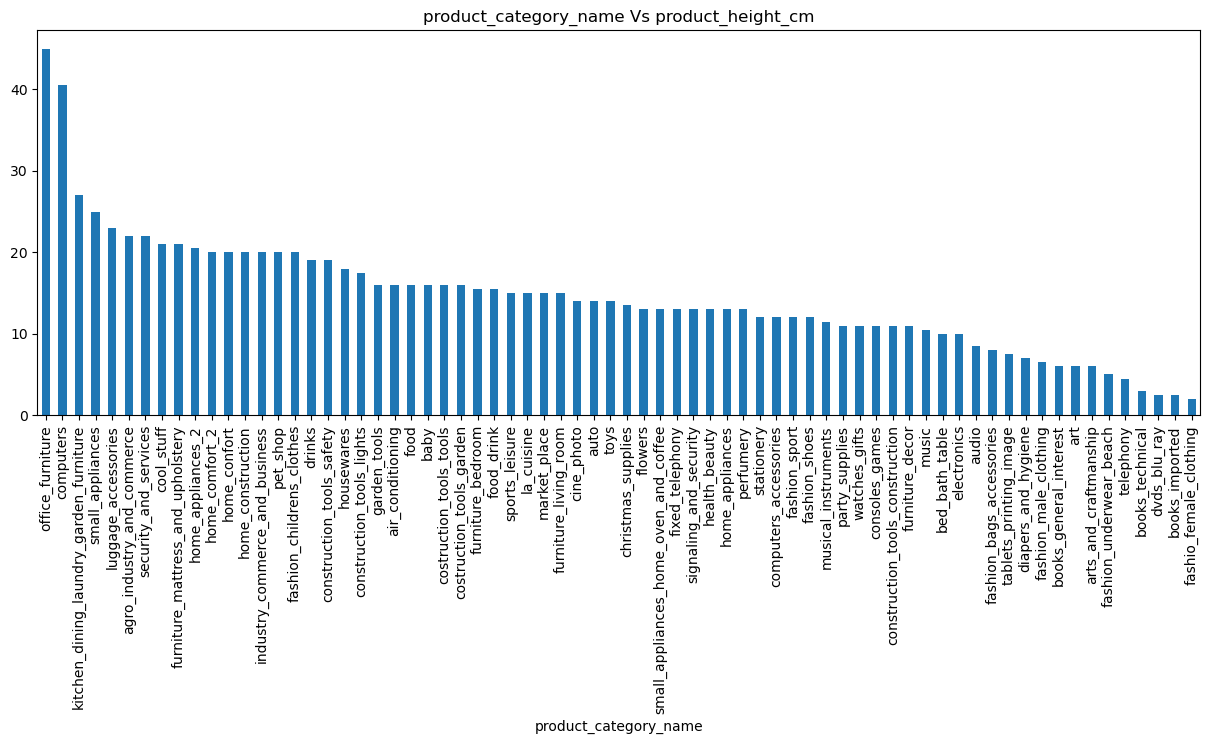

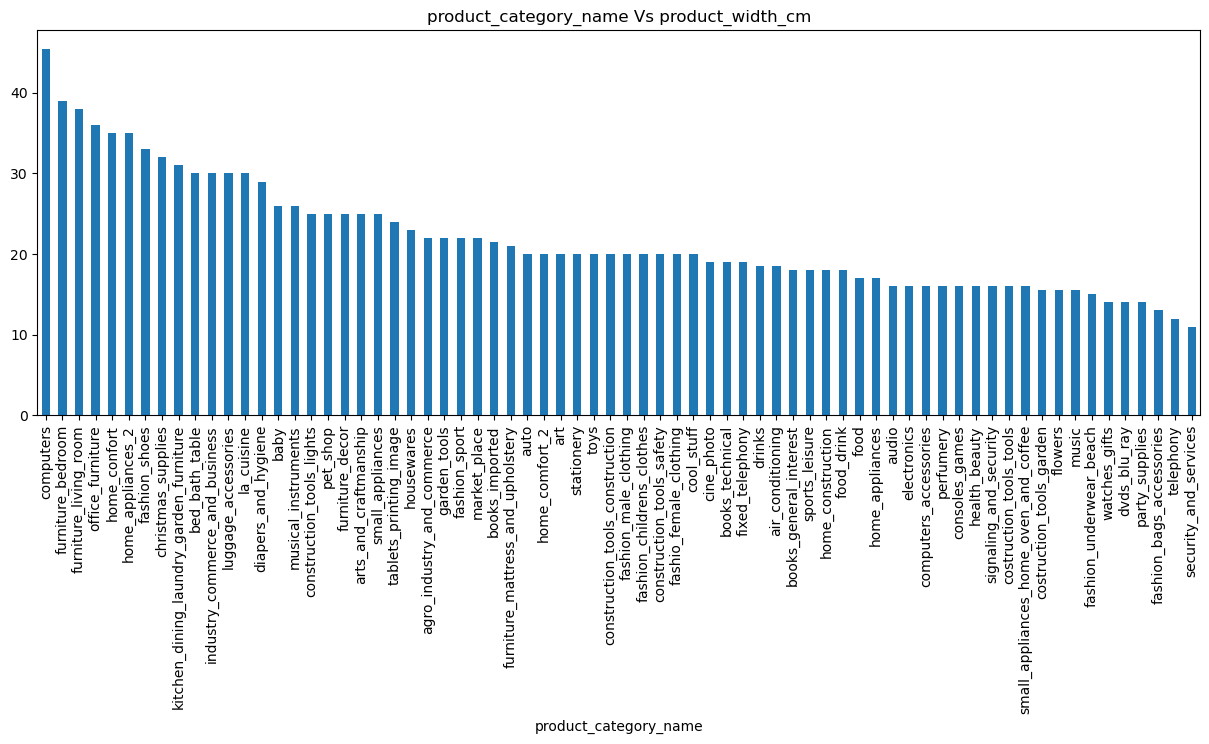

In [110]:
for i in num_cols:
    plt.figure(figsize=(15,5))
    df_products.groupby(by='product_category_name')[i].median().sort_values(ascending=False).plot.bar()
    plt.title('product_category_name Vs '+i)
    plt.show()

Product_category with highest
- product_weight_g - Office_furniture
- product_length_cm - Office_furniture
- product_height_cm - Office_furniture
- product_width_cm - computers

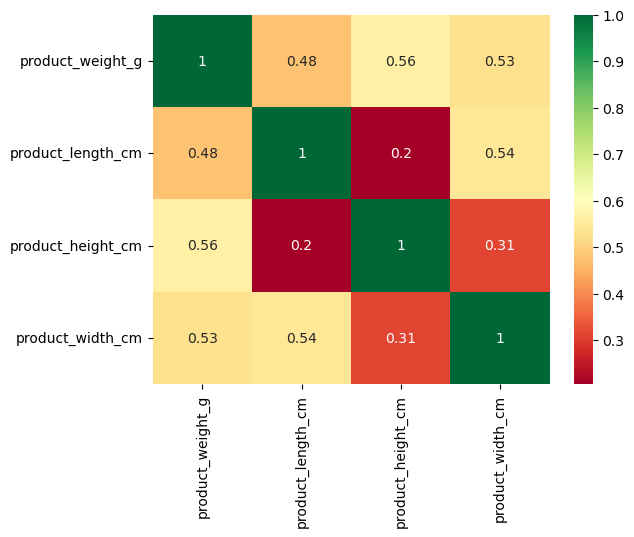

In [111]:
sns.heatmap(df_products[num_cols].corr(),cmap="RdYlGn",annot=True)
plt.show()

some variables are showing moderate correlation, although not strong but they are linearly dependent 
- product_weight and product_height
- product_length and product_width
- product_weight and product_width

### 4.3 payments data

In [112]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


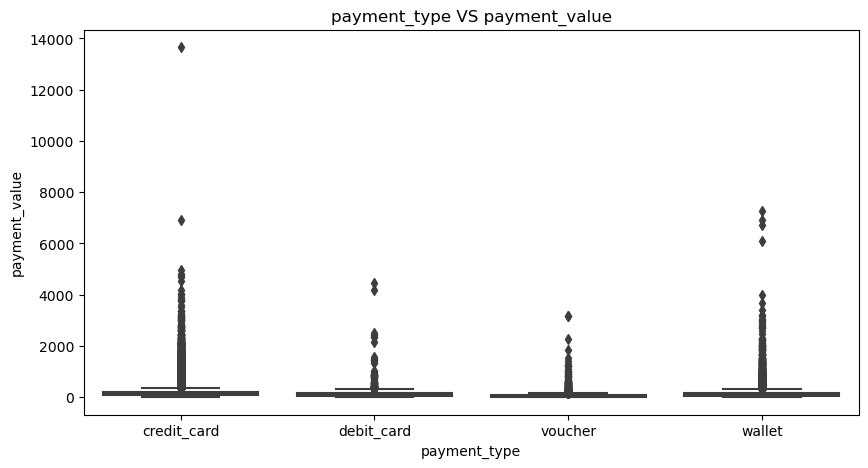

In [113]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_payments,x='payment_type',y='payment_value')
plt.title('payment_type VS payment_value')
plt.show()

- Beacause of outliers, it is difficult to interprete but if we compare max values then we can say that customers prefer credit_card for higher payment values and voucher for lower payment_value.

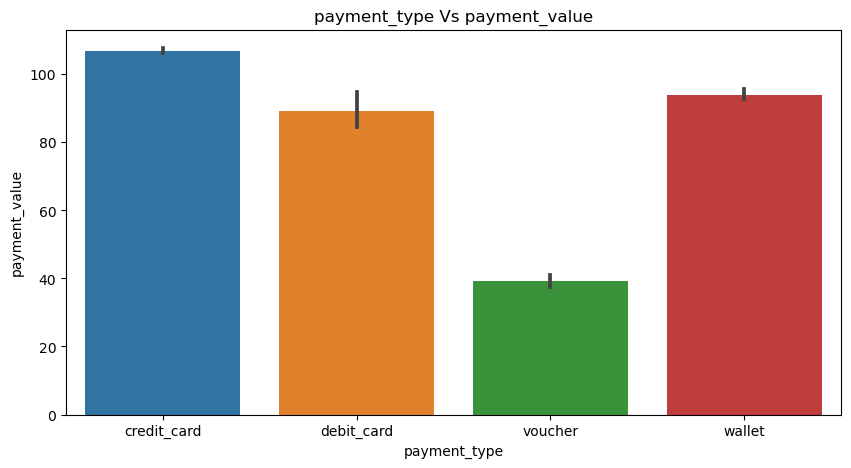

In [114]:
bar_plot(df=df_payments,x='payment_type',y='payment_value',estimator='median')

- it is evident that credit_card is generally used for transactions above $100. 

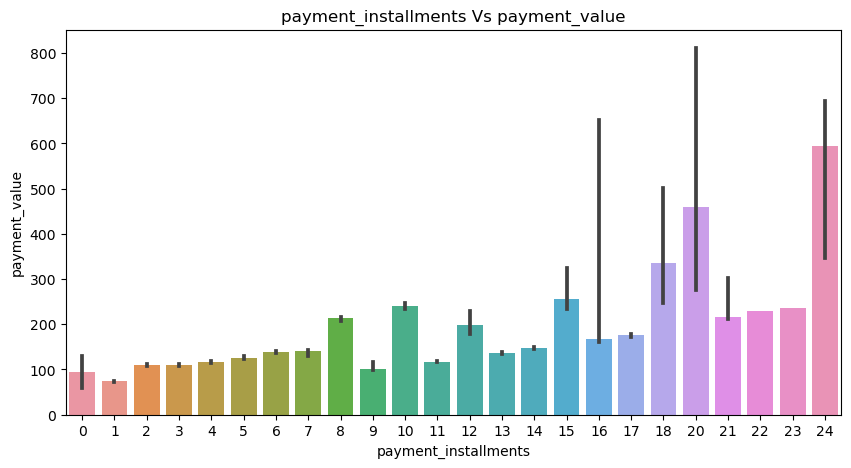

In [115]:
bar_plot(df=df_payments,x='payment_installments',y='payment_value',estimator='median')

- It is evident that as the payment_value increases, customers tend to opt for higher number of installments.

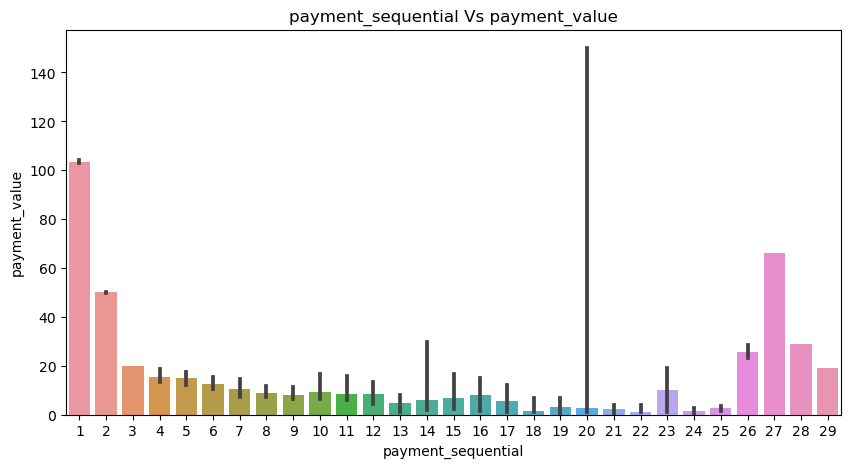

In [116]:
bar_plot(df=df_payments,x='payment_sequential',y='payment_value',estimator='median')

- As we have already seen that majority of orders were paid through single payment mode only, but we can observe a declining trend in payment value as the sequence of payment increases.
- The major amount of payment_value is paid on the 1st payment of sequencial payments.

# 5. Merged Data

In [117]:
df_retail = df_ord_items.merge(df_products,how='inner',on='product_id')
df_retail = df_retail.merge(df_orders_cleaned,how='inner',on='order_id')
df_retail = df_retail.merge(df_payments,how='inner',on='order_id')
df_retail = df_retail.merge(df_customers_cleaned,how='inner',on='customer_id')
df_retail

,order_id,order_item_id,product_id,price,shipping_charges,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,order_estimated_delivery_date,order_yr_mon,is_order_delayed,payment_sequential,payment_type,payment_installments,payment_value,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,toys,650.0,28.0,9.0,14.0,...,2017-09-29,2017-09-01,Not Delayed,1,credit_card,2,72.19,28013,campos dos goytacazes,RJ
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,55.9,17.96,toys,650.0,28.0,9.0,14.0,...,2017-07-26,2017-06-01,Not Delayed,1,wallet,1,73.86,75800,jatai,GO
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,64.9,18.33,toys,650.0,28.0,9.0,14.0,...,2018-06-07,2018-05-01,Not Delayed,1,credit_card,2,83.23,30720,belo horizonte,MG
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,58.9,16.17,toys,650.0,28.0,9.0,14.0,...,2017-08-25,2017-08-01,Not Delayed,1,credit_card,3,75.07,83070,sao jose dos pinhais,PR
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29,toys,650.0,28.0,9.0,14.0,...,2017-09-01,2017-08-01,Not Delayed,1,credit_card,4,72.19,36400,conselheiro lafaiete,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115030,ffea406a848c8afe4dec22bf6290ba00,1,801a695ff5c0c14970a71a4ceb70989e,146.9,15.20,toys,350.0,18.0,15.0,16.0,...,2017-04-05,2017-03-01,Delayed,1,wallet,1,162.10,38411,uberlandia,MG
115031,ffebd80e3291e811c308365936897efd,1,4cc4d02efc8f249c13355147fb44e34d,129.9,51.20,toys,6700.0,35.0,12.0,22.0,...,2018-08-07,2018-07-01,Not Delayed,1,credit_card,1,181.10,28740,conceicao de macabu,RJ
115032,fff7c4452f050315db1b3f24d9df5fcd,1,dd469c03ad67e201bc2179ef077dcd48,736.0,20.91,watches_gifts,400.0,19.0,9.0,15.0,...,2017-06-26,2017-06-01,Not Delayed,1,credit_card,1,756.91,27261,volta redonda,RJ
115033,fffa82886406ccf10c7b4e35c4ff2788,1,bbe7651fef80287a816ead73f065fc4b,229.9,44.02,toys,2700.0,60.0,15.0,15.0,...,2018-01-24,2017-12-01,Not Delayed,1,credit_card,7,273.92,59955,tenente ananias,RN


In [118]:
df_retail.isna().sum()

order_id                         0
order_item_id                    0
product_id                       0
price                            0
shipping_charges                 0
product_category_name            0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
customer_id                      0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_timestamp        0
order_estimated_delivery_date    0
order_yr_mon                     0
is_order_delayed                 0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

In [119]:
df_retail.shape

(115035, 24)

In [120]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115035 entries, 0 to 115034
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115035 non-null  object        
 1   order_item_id                  115035 non-null  int64         
 2   product_id                     115035 non-null  category      
 3   price                          115035 non-null  float64       
 4   shipping_charges               115035 non-null  float64       
 5   product_category_name          115035 non-null  category      
 6   product_weight_g               115035 non-null  float64       
 7   product_length_cm              115035 non-null  float64       
 8   product_height_cm              115035 non-null  float64       
 9   product_width_cm               115035 non-null  float64       
 10  customer_id                    115035 non-null  object        
 11  

In [121]:
# The datatype of columns, basis on which we performed merge, have been changed to object, let's change it back to category.
for col in df_retail.select_dtypes('object').columns:
    df_retail[col] = df_retail[col].astype('category')

In [122]:
df_retail.describe(percentiles=[0.25,0.50,0.75,0.90,0.95,0.99])

,order_item_id,price,shipping_charges,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value
count,115035.000000,115035.000000,115035.00000,115035.000000,115035.000000,115035.000000,115035.000000,115035.000000,115035.000000,115035.000000
mean,1.196375,120.083702,19.99557,2107.497144,30.230460,16.590472,23.059095,1.090685,2.936706,171.914291
std,0.699362,183.029335,15.74333,3774.240161,16.127022,13.426352,11.731526,0.684360,2.772365,266.108823
min,1.000000,0.850000,0.00000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000
25%,1.000000,39.900000,13.08000,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.850000
50%,1.000000,74.900000,16.28000,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.190000
75%,1.000000,133.000000,21.18000,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,188.940000
90%,2.000000,229.000000,34.04000,6250.000000,51.000000,31.000000,40.000000,1.000000,8.000000,336.310000
95%,2.000000,349.900000,45.13000,9800.000000,62.000000,45.000000,45.000000,1.000000,10.000000,510.978000
99%,4.000000,890.000000,84.57660,18516.500000,93.000000,65.000000,62.000000,3.000000,10.000000,1202.640000


# 6. Bivariate and Multivariate analysis on merged data

In [123]:
numerical_cols = df_retail.select_dtypes('float64').columns
numerical_cols

Index(['price', 'shipping_charges', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_value'],
      dtype='object')

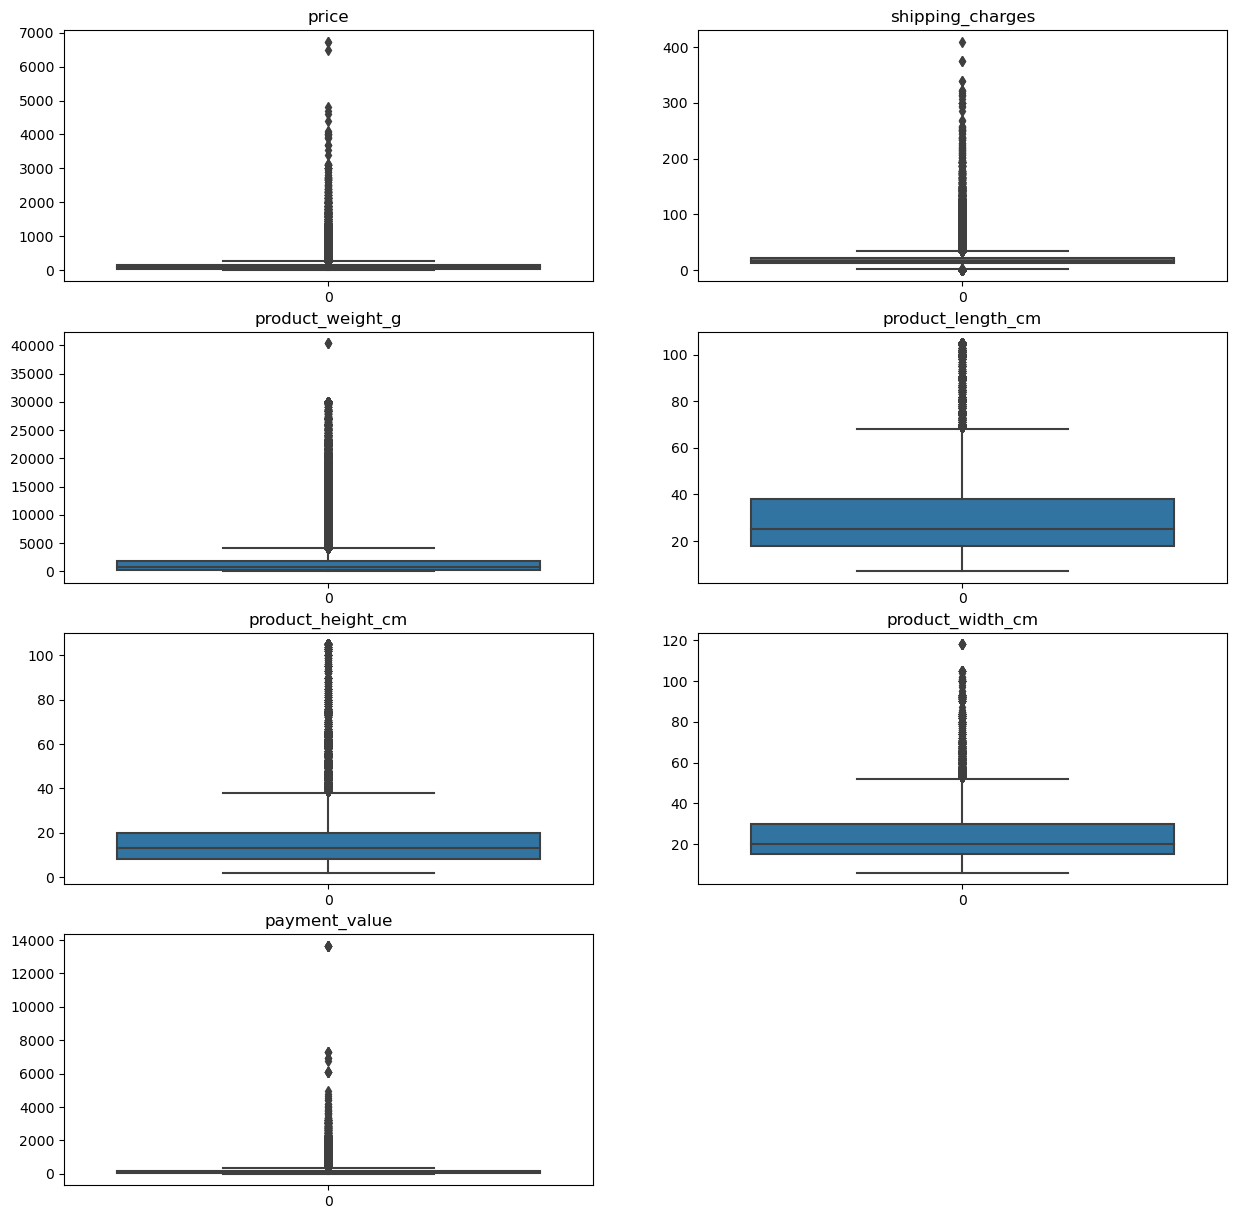

In [124]:
# after merging the data sets, the outliers might have changed, let's check with box plot

plt.figure(figsize=(15,15))
for i,j in enumerate(numerical_cols,1):
    plt.subplot(4,2,i)
    sns.boxplot(df_retail[j])
    plt.title(j)
plt.show()

- The numerical data contains outliers, although extreme they are all valid values so removing them will lead to misinterpretation of results.

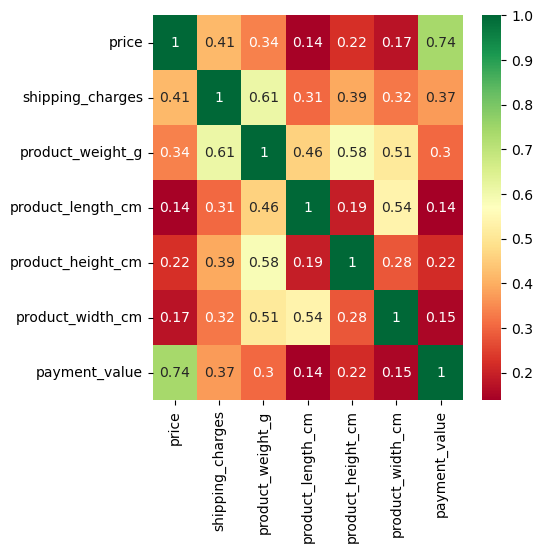

In [125]:
plt.figure(figsize=(5,5))
sns.heatmap(df_retail[numerical_cols].corr(),cmap="RdYlGn",annot=True)
plt.show()

Based on the correlation coefficient, we can say that
- price and payment_value are strongly correlated.
- product_weight_g and shipping_charges show moderate correlation.

Let's also check pair plots to see if we can find any pattern among these variables

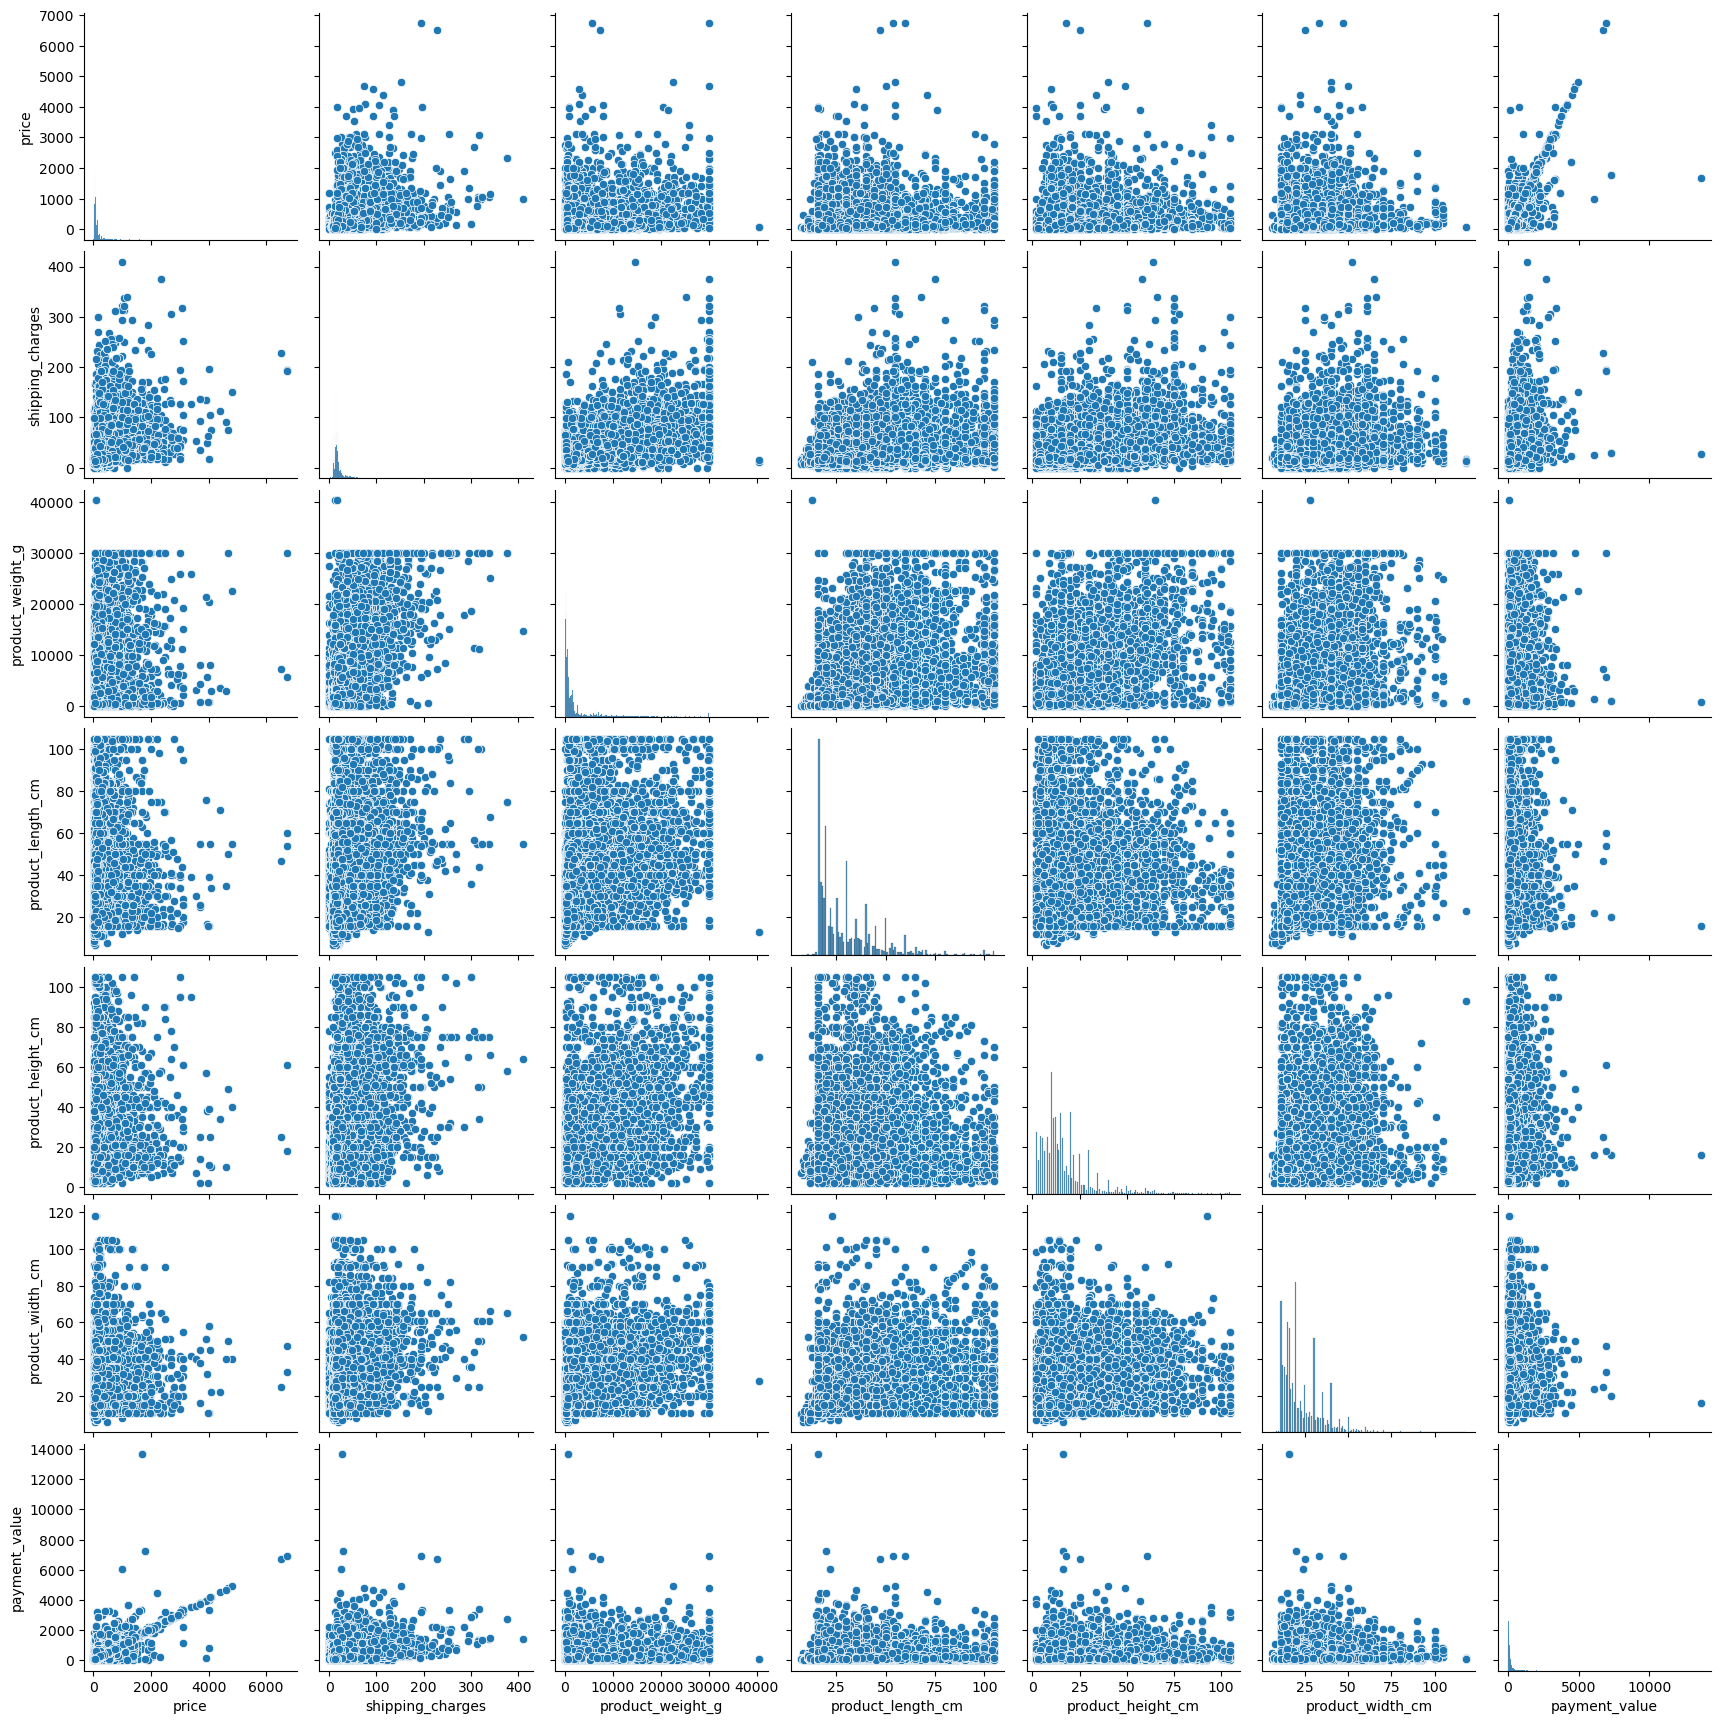

In [126]:
sns.pairplot(df_retail[numerical_cols])
plt.show()

- Apart from the already deduced correlations, majority of the other variables are randomly distributed.

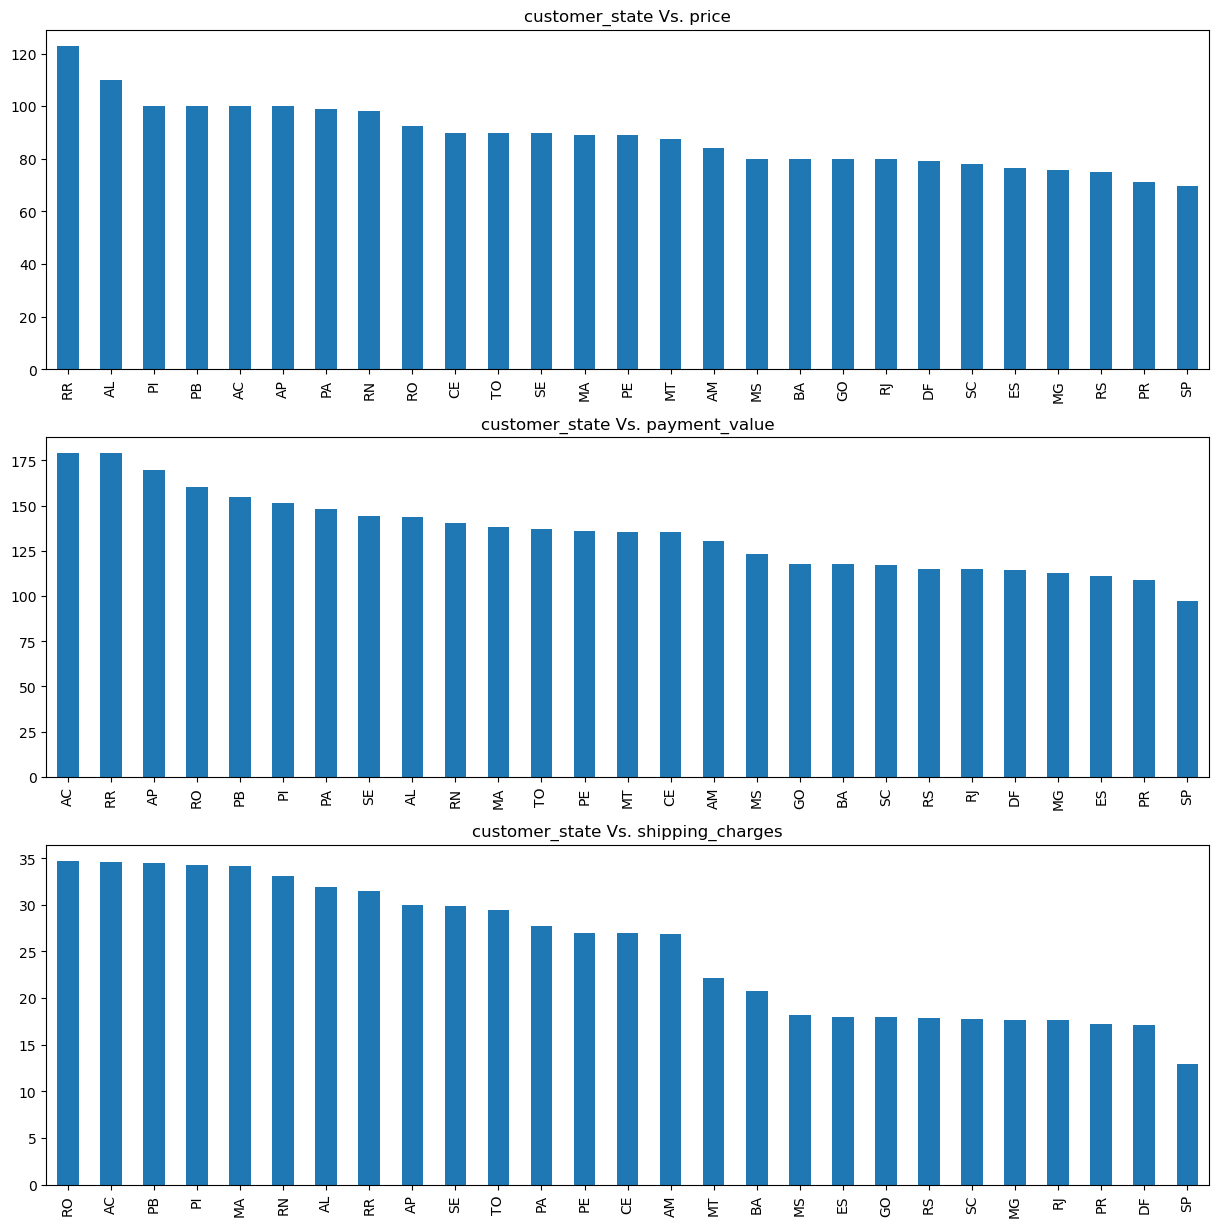

In [127]:
# customer_state

plt.figure(figsize=(15,15))
for i,j in enumerate(['price','payment_value','shipping_charges'],1):
    plt.subplot(3,1,i)
    df_retail.groupby(by='customer_state')[j].median().sort_values(ascending=False).plot.bar()
    plt.title('customer_state Vs. '+j)
    plt.xlabel(None)
plt.show()

- 'AC' state has highest median 'payment_value' where as 'SP' has the lowest value for all 3 variables.

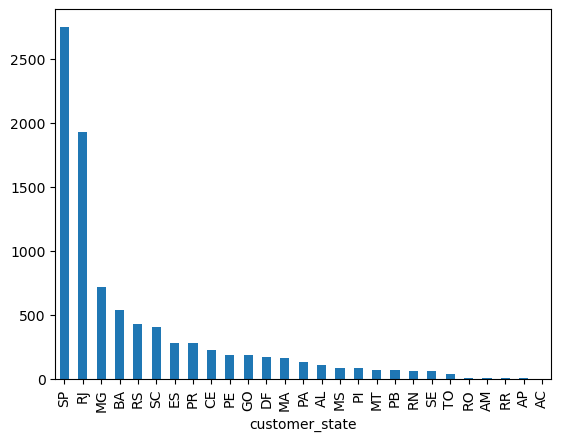

In [128]:
(df_retail[df_retail.is_order_delayed=="Delayed"]).groupby(by='customer_state')['customer_state'].count().sort_values(ascending=False).plot.bar()
plt.show()

- Highest delayed orders were from state 'SP' which happens to have lowest median order price and lowest median shipping_charges. 
- There could be some interesting relationship between shipping_charges and order being delayed.

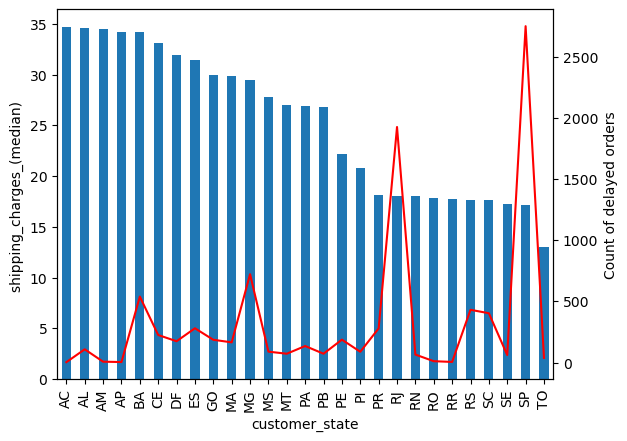

In [129]:
df_retail.groupby(by='customer_state')['shipping_charges'].median().sort_values(ascending=False).plot.bar()
plt.ylabel("shipping_charges_(median) ")
ax2 = plt.twinx()
(df_retail[df_retail.is_order_delayed=="Delayed"]).groupby(by='customer_state')['customer_state'].count().plot(ax=ax2,color="red",ylabel="Count of delayed orders")
plt.show()

#### 'Delayed_orders'
- we can roughly say that the order getting delayed is dependent on the amount of shipping_chareges paid, higher the shipping_charges lower is the possibility of delay.

# 7. Saving the cleaned Dataset

In [130]:
df_retail.to_csv('retail_dataset_cleaned.csv')

# 8. Data Preparation for Market Basket Analysis

#### As we need to perform market basket analysis on the product category, we will only consider order_id and product category columns
#### Also we will need two different tables to perform self join in tableau.


In [131]:
basket = df_retail[['order_id','product_category_name']]
basket.head()

,order_id,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,toys
1,130898c0987d1801452a8ed92a670612,toys
2,532ed5e14e24ae1f0d735b91524b98b9,toys
3,6f8c31653edb8c83e1a739408b5ff750,toys
4,7d19f4ef4d04461989632411b7e588b9,toys


#### we will also make a sr.no column for each category to uniquely identify the categories once self join is performed in Tableau.

In [132]:
categories_list = df_retail.product_category_name.unique().sort_values().tolist()

In [133]:
df_category_id = pd.DataFrame({'Category_id':range(1,len(categories_list)+1),'Category':categories_list})
df_category_id.head()

,Category_id,Category
0,1,agro_industry_and_commerce
1,2,air_conditioning
2,3,art
3,4,arts_and_craftmanship
4,5,audio


In [134]:
df_basket = basket.merge(df_category_id,how='inner',left_on='product_category_name',right_on='Category')
df_basket.drop('Category',axis=1,inplace=True)
df_basket.head()

,order_id,product_category_name,Category_id
0,00010242fe8c5a6d1ba2dd792cb16214,toys,69
1,130898c0987d1801452a8ed92a670612,toys,69
2,532ed5e14e24ae1f0d735b91524b98b9,toys,69
3,6f8c31653edb8c83e1a739408b5ff750,toys,69
4,7d19f4ef4d04461989632411b7e588b9,toys,69


In [135]:
xls = pd.ExcelWriter('Basket_data.xlsx', engine='xlsxwriter')

df_basket.to_excel(xls, sheet_name='ord_prod_1', index = False)
df_basket.to_excel(xls, sheet_name='ord_prod_2', index = False)

xls.save()